##Statistical Analysis Of Electoral Patterns in Indian Democracy(1977-2014)

##Theoretical Description

This project focuses on analyzing the Indian Lok Sabha elections from 1977 to 2014 using real election data. The aim is to study voting patterns, party performance, voter turnout, and other key aspects of the electoral process. By cleaning the data and applying various statistical and visual techniques, the project provides insights into how different political parties have gained or lost public support over time, how voter participation has changed, and what trends can be observed in India's democratic journey. This kind of analysis helps in understanding the structure, behavior, and evolution of Indian elections in a data-driven way.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
lok_df = pd.read_csv("https://samatrix-data.s3.ap-south-1.amazonaws.com/Statistics-Project/ind-lok-sabha.csv")
vidhan_df = pd.read_csv("https://samatrix-data.s3.ap-south-1.amazonaws.com/Statistics-Project/ind-vidhan-sabha.csv")


In [3]:
vidhan_df.head()

,st_name,year,ac_no,ac_name,ac_type,cand_name,cand_sex,partyname,partyabbre,totvotpoll,electors
0,Andhra Pradesh,1978.0,1,Ichapuram,GEN,Manabala Ramarao,M,Independent,IND,813.0,83247
1,Andhra Pradesh,1978.0,1,Ichapuram,GEN,Appadu Sahu,M,Independent,IND,1743.0,83247
2,Andhra Pradesh,1978.0,1,Ichapuram,GEN,Uppada Rangababu,M,Indian National Congress,INC,4427.0,83247
3,Andhra Pradesh,1978.0,1,Ichapuram,GEN,Kalla Balarama Swamy,M,Indian National Congress (I),INC(I),19805.0,83247
4,Andhra Pradesh,1978.0,1,Ichapuram,GEN,Bendalam Venkatesam Sarma,M,Janata Party,JNP,34251.0,83247


In [50]:
lok_df.head()

,st_name,year,pc_no,pc_name,pc_type,cand_name,cand_sex,partyname,partyabbre,totvotpoll,electors,vote_share_percent,rank
73076,West Bengal,2014,42,Birbhum,GEN,None Of The Above,U,NOTA,NOTA,14557,1495089,0.973654,5.0
73077,West Bengal,2014,42,Birbhum,GEN,Syed Siraj Jimmi,M,INC,INC,132084,1495089,8.834524,4.0
73078,West Bengal,2014,42,Birbhum,GEN,Joy Banerjee,M,BJP,BJP,235753,1495089,15.768493,3.0
73079,West Bengal,2014,42,Birbhum,GEN,Dr. Elahi Kamre Mahammad,M,CPM,CPM,393305,1495089,26.306461,2.0
73080,West Bengal,2014,42,Birbhum,GEN,Satabdi Roy,F,AITC,AITC,460568,1495089,30.805390,1.0


In [5]:
vidhan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327294 entries, 0 to 327293
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   st_name     327294 non-null  object 
 1   year        327294 non-null  float64
 2   ac_no       327294 non-null  int64  
 3   ac_name     311211 non-null  object 
 4   ac_type     327294 non-null  object 
 5   cand_name   327294 non-null  object 
 6   cand_sex    321992 non-null  object 
 7   partyname   327294 non-null  object 
 8   partyabbre  324588 non-null  object 
 9   totvotpoll  327287 non-null  float64
 10  electors    327294 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 27.5+ MB


In [6]:
vidhan_df.isnull().sum()

,0
st_name,0
year,0
ac_no,0
ac_name,16083
ac_type,0
cand_name,0
cand_sex,5302
partyname,0
partyabbre,2706
totvotpoll,7


## 1. Party Abbreviation Cleaning

In this step, I create a mapping from each party name to its most frequently used abbreviation, then fill missing abbreviations. I also fill remaining blanks with 'IND' (independent). This helps standardize the data and prepare for meaningful analysis.



In [7]:
# Step a: Create a mapping from party name to most common abbreviation
party_map = lok_df.groupby('partyname')['partyabbre']\
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)\
    .to_dict()

# Step b: Fill missing abbreviations based on mapping
lok_df['partyabbre'] = lok_df.apply(
    lambda row: party_map[row['partyname']] if pd.isnull(row['partyabbre']) and row['partyname'] in party_map
    else row['partyabbre'],
    axis=1
)

# Step c: Fill remaining blanks with 'IND' (Independent)
lok_df['partyabbre'] = lok_df['partyabbre'].fillna('IND')

# Step d: Summary of most frequent parties
party_counts = lok_df['partyabbre'].value_counts().head(10)
print("Top 10 most frequent party abbreviations:")
print(party_counts)


Top 10 most frequent party abbreviations:
partyabbre
IND    41127
INC     4800
BJP     3350
BSP     2624
SP      1057
JD       943
CPM      770
DDP      716
JNP      675
CPI      608
Name: count, dtype: int64


###  Observation

- The most frequent party abbreviations include 'INC', 'BJP', 'BSP', and 'IND'.
- This step ensures consistency in abbreviations, allowing for accurate analysis of party performance and trends.
- It also helps avoid missing values that might skew group-based calculations later.


## 2. Standardize Abbreviations

Some political parties have inconsistent labels across years. For example, 'INC(I)' and 'INC' refer to the same party but are written differently. So I will replace such variations to ensure data uniformity.


In [8]:
# Step a: Remove formatting variations (dots, spacing, case)
lok_df['partyabbre'] = lok_df['partyabbre'].str.replace(r"[.]", "", regex=True).str.upper().str.strip()

# Step b: Replace known inconsistent abbreviations with standardized ones
abbreviation_fixes = {
    'INC(I)': 'INC',
    'INC(I) ': 'INC',
    'I.N.C': 'INC',
    'INCP': 'INC',
    'BJP.': 'BJP',
    'JDS': 'JD(S)',
    'JDU': 'JD(U)',
    'JD': 'JD',
    'SP.': 'SP',
    'BSP.': 'BSP',
    'AITC.': 'AITC',
    'AITMC': 'AITC',
    'AITMC.': 'AITC',
    'CONG(I)': 'INC',
    'SAD(M)': 'SAD'
}

lok_df['partyabbre'] = lok_df['partyabbre'].replace(abbreviation_fixes)

# Unique party abbreviations after cleaning
print("Unique standardized party abbreviations:")
print(sorted(lok_df['partyabbre'].dropna().unique()))

Unique standardized party abbreviations:
['A S P', 'AA S P', 'AAAP', 'AAMJP', 'AAP', 'AB', 'ABAS', 'ABBNS', 'ABBP', 'ABCD(A', 'ABCD(A)', 'ABDBM', 'ABDD', 'ABDUP', 'ABGLP', 'ABGMKP', 'ABGP', 'ABHKP', 'ABHM', 'ABHS', 'ABJC', 'ABJND', 'ABJP', 'ABJS', 'ABJVP', 'ABKMM', 'ABLTASJM', 'ABLTC', 'ABLTP', 'ABMAD', 'ABML(S)', 'ABMP', 'ABMSD', 'ABMSK', 'ABMSKP', 'ABP', 'ABRAHP', 'ABRC(D)', 'ABRRP', 'ABRRP(P)', 'ABRS', 'ABRSSD', 'ABSC', 'ABSP', 'ABSR', 'ABSSP', 'ABVCP', 'AC', 'ACNC', 'AD', 'ADC', 'ADK', 'ADMK', 'ADPT', 'ADSMK', 'ADSP', 'ADUP', 'AGP', 'AGRJP', 'AHF', 'AHL', 'AIACP', 'AIAHMJKP', 'AIBS', 'AIC', 'AICP', 'AIDPF', 'AIDWC', 'AIFB', 'AIFB(S)', 'AIGC', 'AIIC(S)', 'AIIC(T)', 'AIJMK', 'AIMF', 'AIMIM', 'AIMLF', 'AIMPR', 'AINRC', 'AIPF', 'AIRJP', 'AIRKC', 'AIRP', 'AIRSP', 'AITC', 'AIUDF', 'AIVP', 'AJBP', 'AJD', 'AJKMP', 'AJKPPF', 'AJP', 'AJSP', 'AJSU', 'AJSUP', 'AKAAD', 'AKAKRP', 'AKBAP', 'AKBJHP', 'AKBMP', 'AKD', 'AKMDMP', 'ALD', 'ALHP', 'AMB', 'AMI', 'AMP', 'AMS', 'ANC', 'ANP', 'AOP', 'AP', 'A

### Observation

- Inconsistencies like 'INC(I)' to 'INC' were corrected.
- This ensures that the same party is not counted multiple times under different abbreviations.
- Clean party labels are crucial for time-series and group-wise comparisons.


## 3. Data Type & Missing Value Handling

- Convert the 'year' column to integer format
- Fill missing candidate genders with 'U' (unknown)
- Drop rows where total votes polled (totvotpoll) are missing


In [9]:
# Step a: Convert year column to integer
lok_df['year'] = lok_df['year'].astype(int)

# Step b: Fill missing candidate gender with 'U'
lok_df['cand_sex'] = lok_df['cand_sex'].fillna('U')

# Step c: Drop rows with missing total vote polled
before_drop = len(lok_df)
lok_df = lok_df.dropna(subset=['totvotpoll'])
after_drop = len(lok_df)

print(f"Rows before dropping missing 'totvotpoll': {before_drop}")
print(f"Rows after dropping: {after_drop}")

Rows before dropping missing 'totvotpoll': 73081
Rows after dropping: 73081


### Observation

- The 'year' column is now correctly formatted for chronological analysis.
- Missing gender entries are handled gracefully using 'U' instead of dropping.
- Dropping rows without vote data ensures there are no incomplete records.


## 4. Filling Missing Assembly Names

I fill missing ac_name values using the most frequent name for each (state, constituency number) pair.


In [10]:
# Step a: Build a mapping of each (state, constituency number) pair to the most frequently used ac_name
assembly_name_map = (
    vidhan_df
    .dropna(subset=['ac_name'])  # Use only known values
    .groupby(['st_name', 'ac_no'])['ac_name']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .to_dict()
)

# Step b: Use this mapping to fill in missing ac_name values wherever possible
vidhan_df['ac_name'] = vidhan_df.apply(
    lambda row: assembly_name_map.get((row['st_name'], row['ac_no']), row['ac_name']),
    axis=1
)

# Step c: Report how many values are still missing after filling
missing_after_fill = vidhan_df['ac_name'].isna().sum()
print(f"Number of missing 'ac_name' entries after filling: {missing_after_fill}")

Number of missing 'ac_name' entries after filling: 0


### Observation

### Step d: Explanation
- Using the most frequent 'ac_name' for each (state, ac_no) helps standardize constituency names.
- eliminates blanks, and improves data quality for constituency-level analysis across time.

## 5. Initial Data Exploration – Lok Sabha Dataset

In this section, I explore the Lok Sabha dataset to understand its basic structure, size, data types, and missing values. This is an important initial step before any detailed analysis.


In [11]:
# Step a: Check dataset size
num_rows, num_columns = lok_df.shape
print(f"The dataset contains {num_rows} rows and {num_columns} columns.")

# Step b: Preview the first few rows to understand the structure
print("\nPreview of the dataset:")
display(lok_df.head())

# Step c: Inspect data types and missing values
print("\nData types of each column:")
print(lok_df.dtypes)

print("\nMissing values in each column:")
print(lok_df.isna().sum())


The dataset contains 73081 rows and 11 columns.

Preview of the dataset:


,st_name,year,pc_no,pc_name,pc_type,cand_name,cand_sex,partyname,partyabbre,totvotpoll,electors
0,Andaman & Nicobar Islands,1977,1,Andaman & Nicobar Islands,GEN,K.R. Ganesh,M,Independents,IND,25168,85308
1,Andaman & Nicobar Islands,1977,1,Andaman & Nicobar Islands,GEN,Manoranjan Bhakta,M,Indian National Congress,INC,35400,85308
2,Andaman & Nicobar Islands,1980,1,Andaman & Nicobar Islands,GEN,Ramesh Mazumdar,M,Independents,IND,109,96084
3,Andaman & Nicobar Islands,1980,1,Andaman & Nicobar Islands,GEN,Alagiri Swamy,M,Independents,IND,125,96084
4,Andaman & Nicobar Islands,1980,1,Andaman & Nicobar Islands,GEN,Kannu Chemy,M,Independents,IND,405,96084



Data types of each column:
st_name       object
year           int64
pc_no          int64
pc_name       object
pc_type       object
cand_name     object
cand_sex      object
partyname     object
partyabbre    object
totvotpoll     int64
electors       int64
dtype: object

Missing values in each column:
st_name          0
year             0
pc_no            0
pc_name          0
pc_type       8070
cand_name        0
cand_sex         0
partyname        0
partyabbre       0
totvotpoll       0
electors         0
dtype: int64


### Observation
- The dataset has correct data types for analysis.
- Most columns are complete, except pc_type, which has 8070 missing values.
- Key fields like year, cand_name, and totvotpoll are clean.
- The dataset is mostly ready, with minor missing data to fix next.

## 6. Handling Missing Values – Lok Sabha Dataset

In this step, I handle missing values to improve data completeness without losing important records.
- Missing cand_sex is filled with 'U' (unknown).
- Missing pc_type is filled with 'Unknown'.
- Then check for any remaining missing values.


In [12]:
# Step a: Fill missing candidate gender with 'U'
lok_df['cand_sex'] = lok_df['cand_sex'].fillna('U')

# Step b: Fill missing parliamentary constituency type with 'Unknown'
lok_df['pc_type'] = lok_df['pc_type'].fillna('Unknown')

# Step c: Check for any remaining missing values
remaining_missing = lok_df.isna().sum()
print("Remaining missing values after filling:")
print(remaining_missing[remaining_missing > 0])


Remaining missing values after filling:
Series([], dtype: int64)


### Observation
All missing values have been successfully filled.

## 7. Standardizing Party Abbreviations – Lok Sabha Dataset

Even within the same dataset, some political parties may appear under different abbreviations.
For example, 'INC(I)' and 'INC' both refer to the Indian National Congress.

To ensure accurate party-level analysis, I standardize inconsistent abbreviations.


In [13]:
# Step a: Replace known inconsistent party abbreviations with standard ones
abbreviation_fixes = {
    'INC(I)': 'INC',
    'CONG(I)': 'INC',
    'I.N.C': 'INC',
    'B.J.P': 'BJP',
    'B.J.P.': 'BJP',
    'S.P.': 'SP',
    'B.S.P.': 'BSP',
    'J.D.': 'JD',
    'JD(U)': 'JD(U)',
    'JD(S)': 'JD(S)',
    'AITMC': 'AITC',
    'AITMC.': 'AITC',
    'TMC': 'AITC',
    'R.J.D.': 'RJD'
}

lok_df['partyabbre'] = lok_df['partyabbre'].replace(abbreviation_fixes)


### Observation

- I standardized entries like INC(I) to INC to ensure uniformity.
- This step is crucial for avoiding errors in grouping, counting, and plotting party-wise trends.
- Clean party labels allow reliable and consistent analysis across all election years.


## 8. Basic Summary Statistics – Vidhan Sabha Dataset

count unique values in key columns to understand the coverage, diversity, and scale of the Vidhan Sabha dataset.
This gives an idea of how many states, years, constituencies, candidates, and parties are represented.


In [14]:
# Count of unique entries for important columns
num_states = vidhan_df['st_name'].nunique()
num_years = vidhan_df['year'].nunique()
num_constituencies = vidhan_df['ac_no'].nunique()
num_candidates = vidhan_df['cand_name'].nunique()
num_parties = vidhan_df['partyabbre'].nunique()

# Print the summary
print(f"Unique states: {num_states}")
print(f"Unique election years: {num_years}")
print(f"Unique assembly constituencies: {num_constituencies}")
print(f"Unique candidates: {num_candidates}")
print(f"Unique party abbreviations: {num_parties}")

Unique states: 30
Unique election years: 37
Unique assembly constituencies: 425
Unique candidates: 220531
Unique party abbreviations: 1285


### Observation
These counts reflect the large scale and richness of the Vidhan Sabha dataset. With over 2 lakh candidates and more than 1,200 parties, the data captures the diversity, regional complexity, and high competitiveness of state-level elections in India. The wide time range and state coverage make this dataset highly suitable for both temporal and spatial political analysis.

## 9. Candidate Gender Distribution – Vidhan Sabha Dataset

In this section, I visualize the distribution of candidates by gender (Male, Female, Unknown).
I use .value_counts() to get the counts and then plot a pie chart to show proportions.


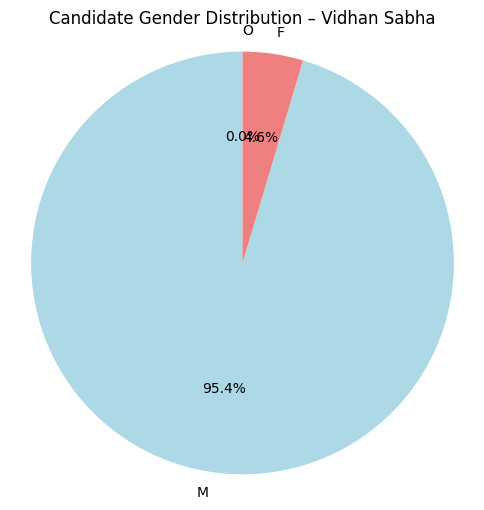

In [15]:
# Step a: Count candidates by gender
gender_counts = vidhan_df['cand_sex'].value_counts()

# Step b–c: Plot as a pie chart
plt.figure(figsize=(6, 6))
colors = ['lightblue', 'lightcoral', 'lightgrey']
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Candidate Gender Distribution – Vidhan Sabha")
plt.axis('equal')  # Equal aspect ratio ensures a circle
plt.show()

### Observation
- Male candidates dominate the elections, making up 95.4% of all candidates.
- Female representation is extremely low at just 4.6%.
- The "Unknown" gender category is negligible (0.0%), indicating either historical gaps in data or rare cases.

This highlights a significant gender imbalance in electoral participation at the Vidhan Sabha level and suggests the need for greater political inclusion of women.

## 10. Trend of Average Candidates per Seat – Vidhan Sabha Dataset

I analyze how the number of candidates contesting each seat has changed over the years.
This helps measure electoral competitiveness and political participation over time.


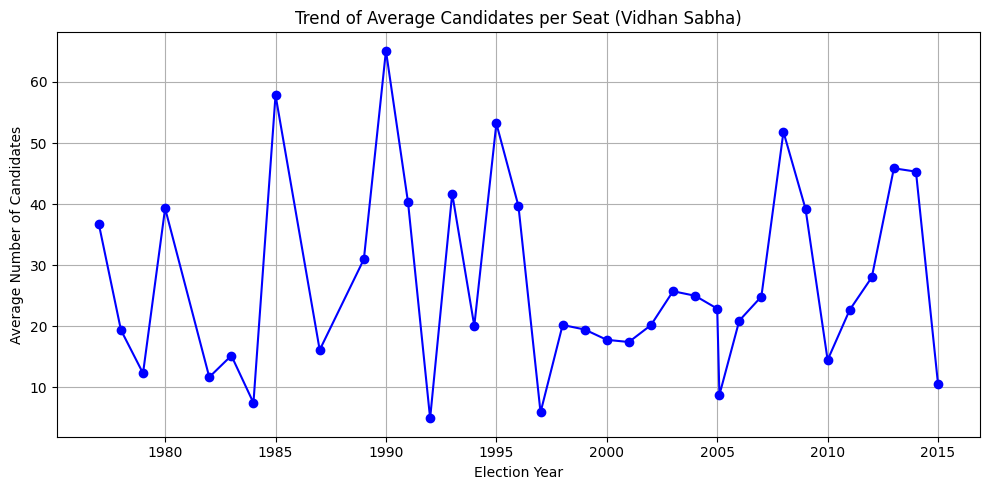

In [16]:
# Step a: Count unique candidates per seat each year
candidates_per_seat = (
    vidhan_df.groupby(['year', 'ac_no'])['cand_name']
    .nunique()
    .reset_index(name='num_candidates')
)

# Step b: Compute average number of candidates per seat for each year
avg_candidates_year = (
    candidates_per_seat.groupby('year')['num_candidates']
    .mean()
    .reset_index(name='avg_candidates_per_seat')
)

# Step c: Plot the trend over time
plt.figure(figsize=(10, 5))
plt.plot(avg_candidates_year['year'], avg_candidates_year['avg_candidates_per_seat'], marker='o', color='blue')
plt.title("Trend of Average Candidates per Seat (Vidhan Sabha)")
plt.xlabel("Election Year")
plt.ylabel("Average Number of Candidates")
plt.grid(True)
plt.tight_layout()
plt.show()


### Observation
- The number of candidates per seat keeps changing over the years.
- Some years like 1985, 1990, and 1995 had many people contesting, showing more competition.
- In other years like 1977, 2000, and 2015, the number was less, which means fewer candidates per seat.

This means the elections were sometimes crowded and sometimes not, depending on the political situation.

## 11. Voter Turnout Analysis by Year – Vidhan Sabha

In this section, I calculate and visualize how voter turnout has changed over the years.
Turnout = (Total Votes Polled / Total Electors) * 100

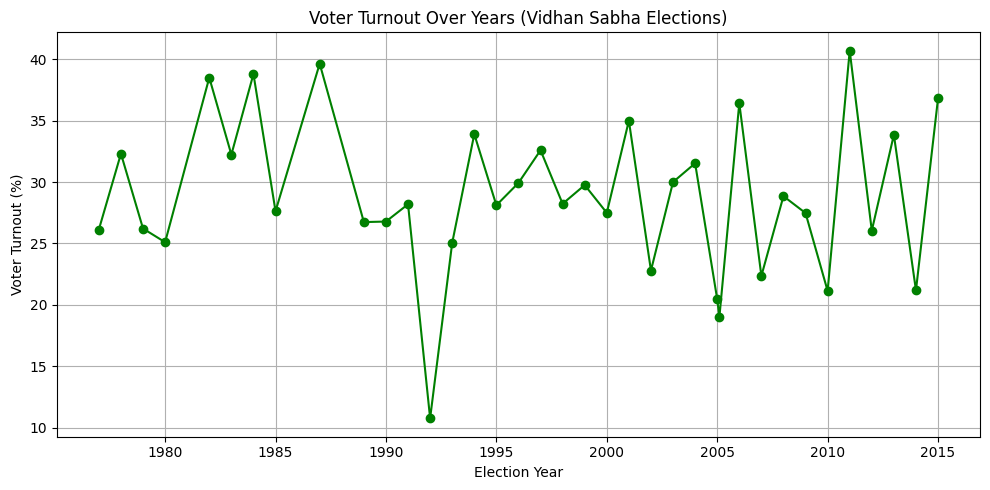

In [17]:
# Step a: Calculate total votes polled and electors per constituency for each year
turnout_constituency = (
    vidhan_df.groupby(['year', 'st_name', 'ac_no'])[['totvotpoll', 'electors']]
    .agg('max')
    .reset_index()
)

# Step b: Sum these values at the national level for each year
yearly_turnout = (
    turnout_constituency.groupby('year')[['totvotpoll', 'electors']]
    .sum()
    .reset_index()
)

# Step c & d: Compute voter turnout percentage
yearly_turnout['voter_turnout_percent'] = (
    yearly_turnout['totvotpoll'] / yearly_turnout['electors']
) * 100

# Step e: Plot a line chart
plt.figure(figsize=(10, 5))
plt.plot(yearly_turnout['year'], yearly_turnout['voter_turnout_percent'], marker='o', color='green')
plt.title("Voter Turnout Over Years (Vidhan Sabha Elections)")
plt.xlabel("Election Year")
plt.ylabel("Voter Turnout (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


###Observation

- Some years like 2013 and 1985 show high turnout (above 35–40%), meaning more people voted.
- Other years like 1992 and 2006 have very low turnout, showing less public participation.


## 12. Top 10 Parties by Candidate Count – Vidhan Sabha Dataset

This section identifies which political parties have fielded the most candidates over the years.
count the candidates per party and visualize the top 10 using a horizontal bar chart.

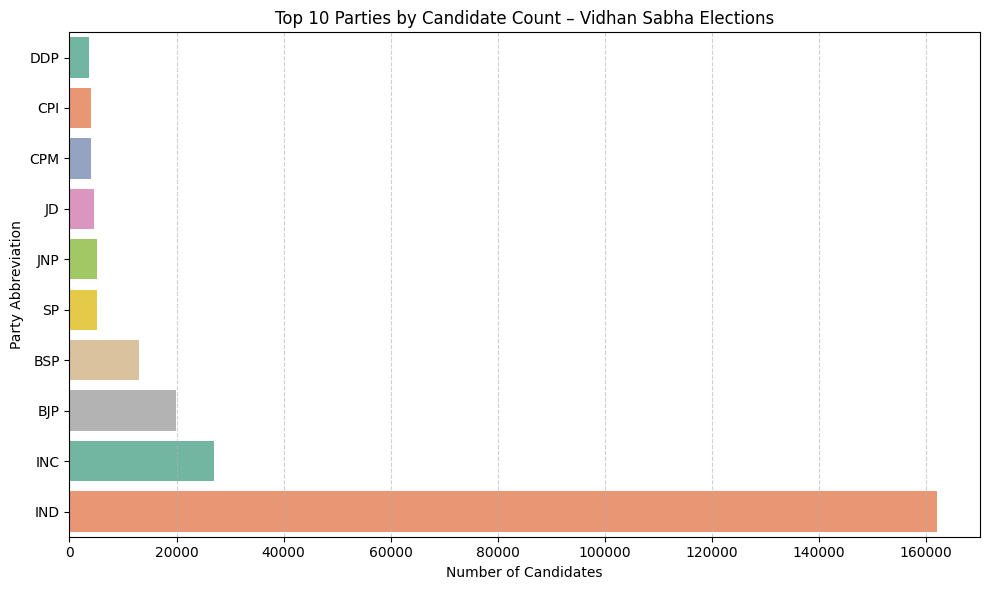

In [18]:
# Step a: Get top 10 parties by number of candidates
top_10_parties = vidhan_df['partyabbre'].value_counts().head(10).sort_values()

# Step b & c: Plot with color coding, no legend
plt.figure(figsize=(10, 6))
sns.barplot(
    y=top_10_parties.index,
    x=top_10_parties.values,
    hue=top_10_parties.index,  # Assigning y to hue
    dodge=False,
    palette='Set2',
    legend=False  # Step c: Hide legend
)

plt.title("Top 10 Parties by Candidate Count – Vidhan Sabha Elections")
plt.xlabel("Number of Candidates")
plt.ylabel("Party Abbreviation")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

###Observation
- IND (Independent) candidates are the highest, with more than 1.5 lakh candidates.
- INC and BJP are the next most active parties, showing their strong presence in state elections.
- Smaller or regional parties like SP, BSP, JD, CPM, CPI, DDP also appear in the top 10.

This shows that while big parties contest widely, many individuals also contest without any party.

## 13. Identify Winning Candidates – Vidhan Sabha

I identify winners in each constituency by finding the candidate with the highest number of votes.
I also filter winners for a specific state like Gujarat to view regional results.


In [19]:
# Step a & b: Select the winning candidate in each constituency (highest totvotpoll)
# Group by year, state, and constituency, then get the index of row with max votes in each group

# Drop rows with missing total votes polled in vidhan_df before grouping
winners_df = (
    vidhan_df.dropna(subset=['totvotpoll']) # Drop rows where totvotpoll is NaN
    .groupby(['year', 'st_name', 'ac_no'])['totvotpoll'].idxmax()
)

# winners_df now contains the index of the winning candidate for each group.
# Use these indices to select the full rows from the original vidhan_df
winners_df = vidhan_df.loc[winners_df].reset_index(drop=True)


# Step c: Filter winners for a specific state (e.g., Gujarat)
gujarat_winners = winners_df[winners_df['st_name'] == 'Gujarat']

# Step d: Show a sample of winners from Gujarat
sample = gujarat_winners[['year', 'ac_no', 'ac_name', 'cand_name', 'partyabbre', 'totvotpoll']]
print("Sample of winning candidates from Gujarat:")
display(sample.head())

Sample of winning candidates from Gujarat:


,year,ac_no,ac_name,cand_name,partyabbre,totvotpoll
3899,1980.0,1,Abdasa,Kharashanker Vithaldas Joshi,INC(I),16665.0
3900,1980.0,2,Mandvi,Sanghvi Jaykumar Chunilal,INC(I),17255.0
3901,1980.0,3,Bhuj,Shah Mohanlal Nemchand,INC(I),21243.0
3902,1980.0,4,Mundra,Dafda Virji Bhimji,INC(I),10048.0
3903,1980.0,5,Anjar,Khimjibhai Jesangbhai,INC(I),26293.0


### Observation
- The winners from Gujarat in the year 1980 were all from the INC(I) party.
- Each winner is selected based on the highest number of votes polled (totvotpoll) in their constituency.


## 14. Compare Vote Share vs Seat Share – National Level (Vidhan Sabha)

I compare how many votes each party got (vote share) vs. how many seats they won (seat share).
This shows how effectively parties convert votes into wins.


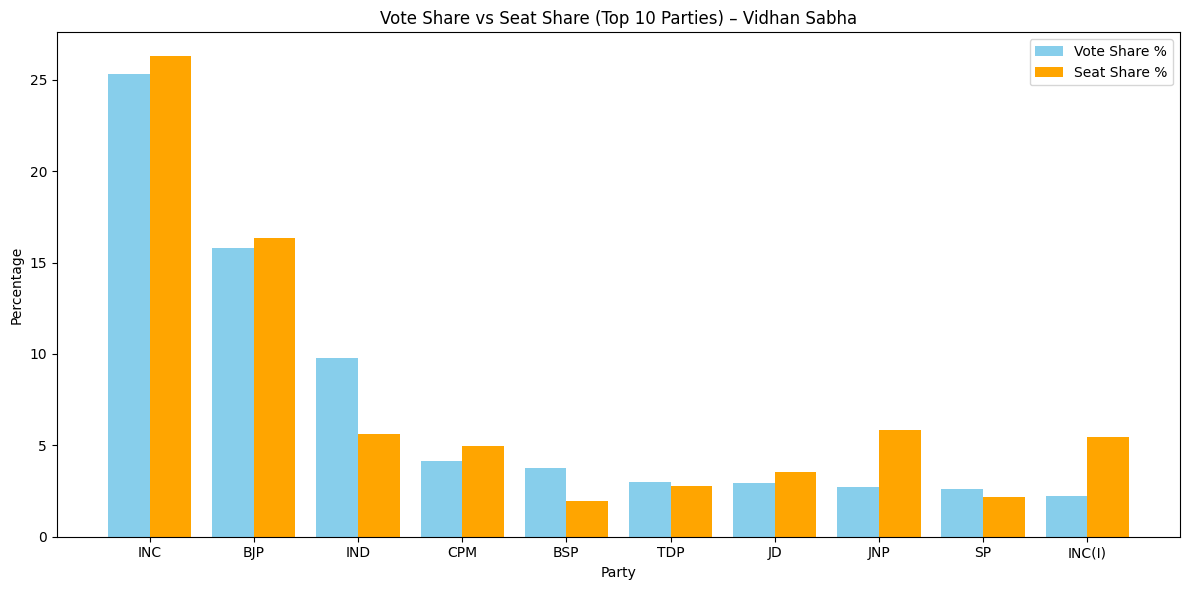

In [20]:
# Step a: Calculate vote share for each party
party_votes = vidhan_df.groupby('partyabbre')['totvotpoll'].sum()  # total votes per party
total_votes = party_votes.sum()  # total votes cast in total
party_vote_share = (party_votes / total_votes * 100).reset_index()
party_vote_share.columns = ['Party', 'Vote_Share']  # rename for clarity

# Step b: Calculate seat share for each party
# Drop rows with missing vote counts to ensure accurate winner selection
winners_indices = vidhan_df.dropna(subset=['totvotpoll']).groupby(['year', 'st_name', 'ac_no'])['totvotpoll'].idxmax()

# Select the winning rows using the valid indices
winners_df = vidhan_df.loc[winners_indices]

# Count number of seats won by each party and convert to percentage
party_seats = winners_df['partyabbre'].value_counts(normalize=True) * 100
party_seat_share = party_seats.reset_index()
party_seat_share.columns = ['Party', 'Seat_Share']

# Step c: Merge both vote share and seat share into one table
share_df = pd.merge(party_vote_share, party_seat_share, on='Party')

# Step d: Select top 10 parties by vote share
top_parties = share_df.sort_values('Vote_Share', ascending=False).head(10)

# Step e: Plot side-by-side bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
bar_width = 0.4
x = range(len(top_parties))

# Vote Share bars
plt.bar(x, top_parties['Vote_Share'], width=bar_width, label='Vote Share %', color='skyblue')

# Seat Share bars (shifted right)
plt.bar([p + bar_width for p in x], top_parties['Seat_Share'], width=bar_width, label='Seat Share %', color='orange')

# Set x-axis labels
plt.xticks([p + bar_width / 2 for p in x], top_parties['Party'])

# Add titles and labels
plt.xlabel('Party')
plt.ylabel('Percentage')
plt.title('Vote Share vs Seat Share (Top 10 Parties) – Vidhan Sabha')
plt.legend()
plt.tight_layout()
plt.show()


### Observation
- Some parties like BJP and INC had both high vote share and high seat share, which means many people voted for them and they also won in many areas.
- Independent candidates (IND) got quite a few votes overall, but they didn’t win many seats. That’s probably because their votes were spread out and not strong enough in any one area to win.

<Figure size 800x800 with 0 Axes>

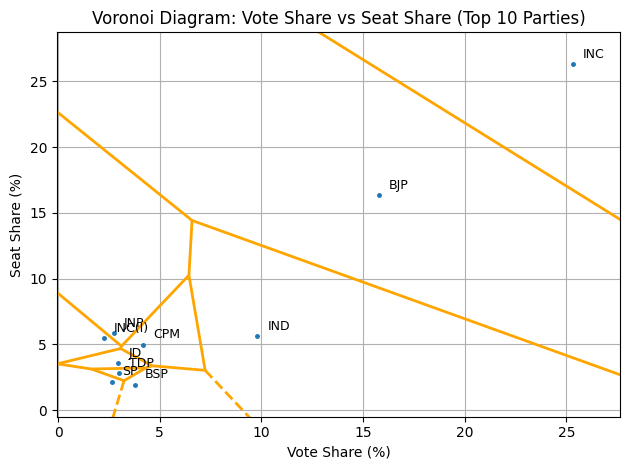

In [21]:
from scipy.spatial import Voronoi, voronoi_plot_2d
# Step 1: Prepare the points (Vote Share vs Seat Share)
points = top_parties[['Vote_Share', 'Seat_Share']].values

# Step 2: Create Voronoi diagram
vor = Voronoi(points)

# Step 3: Plot Voronoi diagram
fig = plt.figure(figsize=(8, 8))
voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', line_width=2, point_size=5)

# Step 4: Annotate each region with Party name
for i, (x, y) in enumerate(points):
    plt.text(x + 0.5, y + 0.5, top_parties['Party'].iloc[i], fontsize=9)

plt.xlabel("Vote Share (%)")
plt.ylabel("Seat Share (%)")
plt.title("Voronoi Diagram: Vote Share vs Seat Share (Top 10 Parties)")
plt.grid(True)
plt.tight_layout()
plt.show()

## 15. Gujarat – Top 3 Parties' Seat Trends Over Time (Vidhan Sabha)

I focus on Gujarat to analyze which 3 parties have won the most seats over the years and how their performance has changed in state elections.


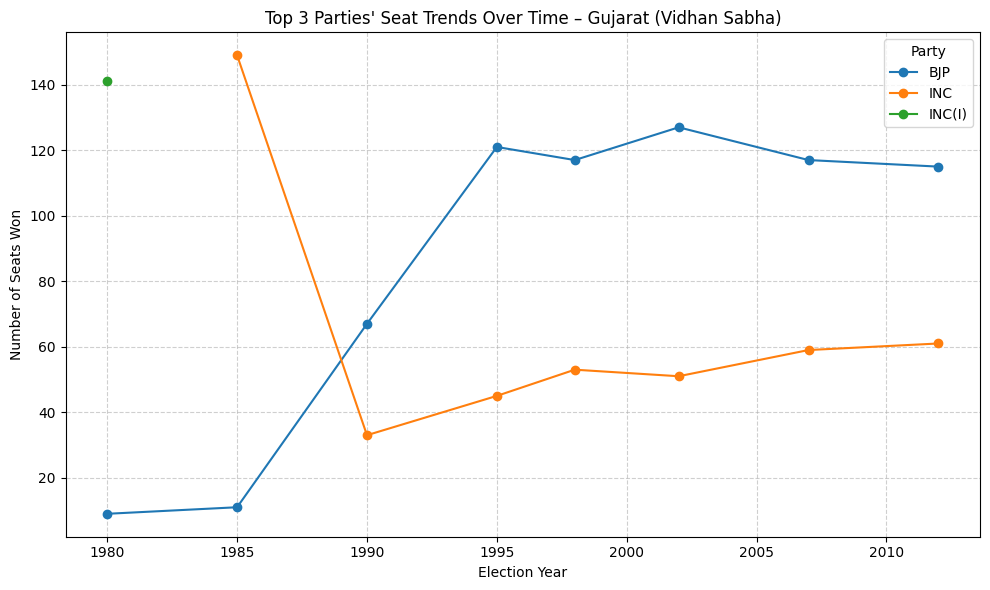

In [22]:
# Step a: Remove rows with missing 'totvotpoll' before selecting winners
vidhan_clean = vidhan_df.dropna(subset=['totvotpoll'])

# Step b: Identify winners (max votes) for each (year, state, ac_no)
winners_df = (
    vidhan_clean.loc[
        vidhan_clean.groupby(['year', 'st_name', 'ac_no'])['totvotpoll'].idxmax()
    ]
    .reset_index(drop=True)
)

# Step c: Filter only winners from Gujarat
gujarat_winners = winners_df[winners_df['st_name'] == 'Gujarat']


# Step d: Get top 3 parties in Gujarat by seats won
top3_gujarat_parties = (
    gujarat_winners['partyabbre'].value_counts()
    .head(3)
    .index.tolist()
)

# Step e: Filter to top 3 parties
gujarat_top3_df = gujarat_winners[gujarat_winners['partyabbre'].isin(top3_gujarat_parties)]

# Step f: Count seats per year for each party
seats_by_year = (
    gujarat_top3_df.groupby(['year', 'partyabbre'])
    .size()
    .reset_index(name='seats_won')
)

# Step g: Plot seat trends
plt.figure(figsize=(10, 6))
for party in top3_gujarat_parties:
    party_data = seats_by_year[seats_by_year['partyabbre'] == party]
    plt.plot(party_data['year'], party_data['seats_won'], marker='o', label=party)

plt.title("Top 3 Parties' Seat Trends Over Time – Gujarat (Vidhan Sabha)")
plt.xlabel("Election Year")
plt.ylabel("Number of Seats Won")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Party")
plt.tight_layout()
plt.show()


### Observation
- In the early years (1980s), a party called INC(I) and later INC won most of the seats in Gujarat. They were very strong back then.
- But after 1990, INC started losing strength and won fewer and fewer seats.
- Meanwhile, BJP started small but kept growing. Around 2002, they became the top party and have stayed strong since then.

## 16. Vote Share Trend of Top 3 Parties – Gujarat

As per previous analysis I seen how many seats the top 3 parties won in Gujarat, let's analyze how their vote share changed over time.


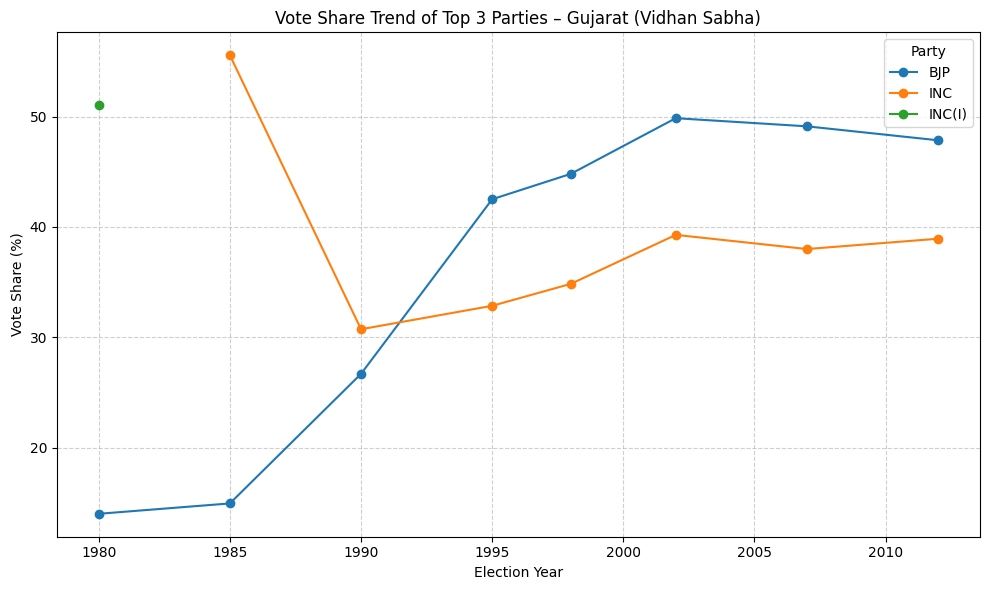

In [23]:
# Step a: Filter Vidhan Sabha data for Gujarat
gujarat_df = vidhan_df[vidhan_df['st_name'] == 'Gujarat']

# Step b: Get top 3 parties based on seats won (reuse from Section 15)
top3_gujarat_parties = (
    gujarat_df.dropna(subset=['totvotpoll'])
    .groupby(['year', 'ac_no'])['totvotpoll']
    .idxmax()
)

gujarat_winners = vidhan_df.loc[top3_gujarat_parties]
top3 = (
    gujarat_winners['partyabbre']
    .value_counts()
    .head(3)
    .index
    .tolist()
)

# Step c: Filter Gujarat data for only top 3 parties
gujarat_top3 = gujarat_df[gujarat_df['partyabbre'].isin(top3)]

# Step d: Group by year and party to get total votes
party_year_votes = (
    gujarat_top3.groupby(['year', 'partyabbre'])['totvotpoll']
    .sum()
    .reset_index()
    .rename(columns={'totvotpoll': 'party_votes'})
)

# Step e: Get total votes in Gujarat for each year
total_votes_year = (
    gujarat_df.groupby('year')['totvotpoll']
    .sum()
    .reset_index()
    .rename(columns={'totvotpoll': 'total_votes'})
)

# Step f: Merge and calculate vote share
vote_share_trend = pd.merge(party_year_votes, total_votes_year, on='year')
vote_share_trend['vote_share_percent'] = (vote_share_trend['party_votes'] / vote_share_trend['total_votes']) * 100

# Step g: Plot vote share trend
plt.figure(figsize=(10, 6))
for party in top3:
    party_data = vote_share_trend[vote_share_trend['partyabbre'] == party]
    plt.plot(party_data['year'], party_data['vote_share_percent'], marker='o', label=party)

plt.title("Vote Share Trend of Top 3 Parties – Gujarat (Vidhan Sabha)")
plt.xlabel("Election Year")
plt.ylabel("Vote Share (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Party")
plt.tight_layout()
plt.show()


###Observation
- BJP started with a low vote share in 1980 but kept growing steadily. Around 2002, it reached its highest point and stayed strong up to 2010. This shows how BJP slowly became the most popular party among voters.
- INC(I) had a large vote share only in 1980, but after that, it disappears — likely because it merged or changed.
- INC had a strong moment in 1985, winning the most votes that year. But after that, their popularity went down. Though there was a small rise again around 2007–2010, it never went back to its earlier strength.

## 17. Age Distribution of Candidates – Vidhan Sabha

This section shows the age distribution of election candidates using a histogram.  
Understanding candidate age trends can give insights into political diversity and youth representation.


/tmp/ipython-input-24-3451792726.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vidhan_df['vote_share_percent'] = (vidhan_df['totvotpoll'] / vidhan_df['electors']) * 100
/tmp/ipython-input-24-3451792726.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gujarat_df['rank'] = gujarat_df.groupby(['year', 'ac_no'])['totvotpoll'].rank(method='first', ascending=False)


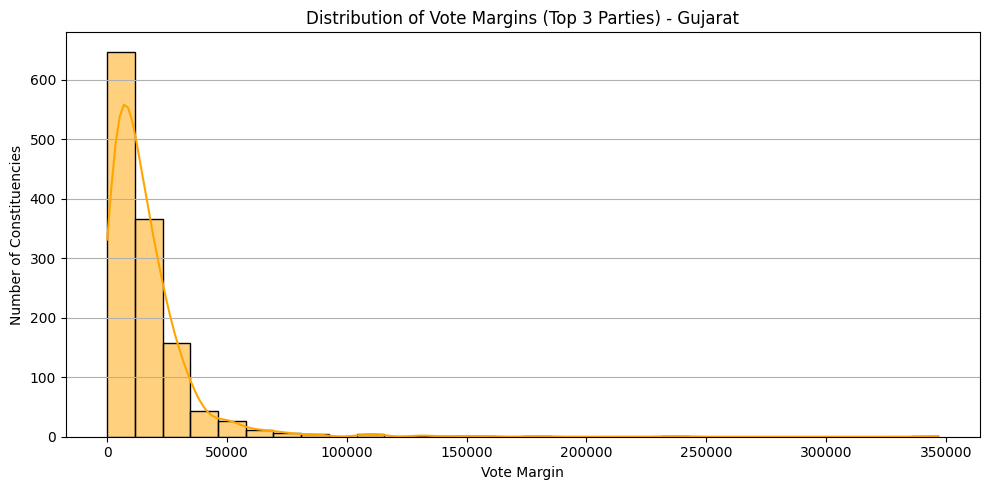

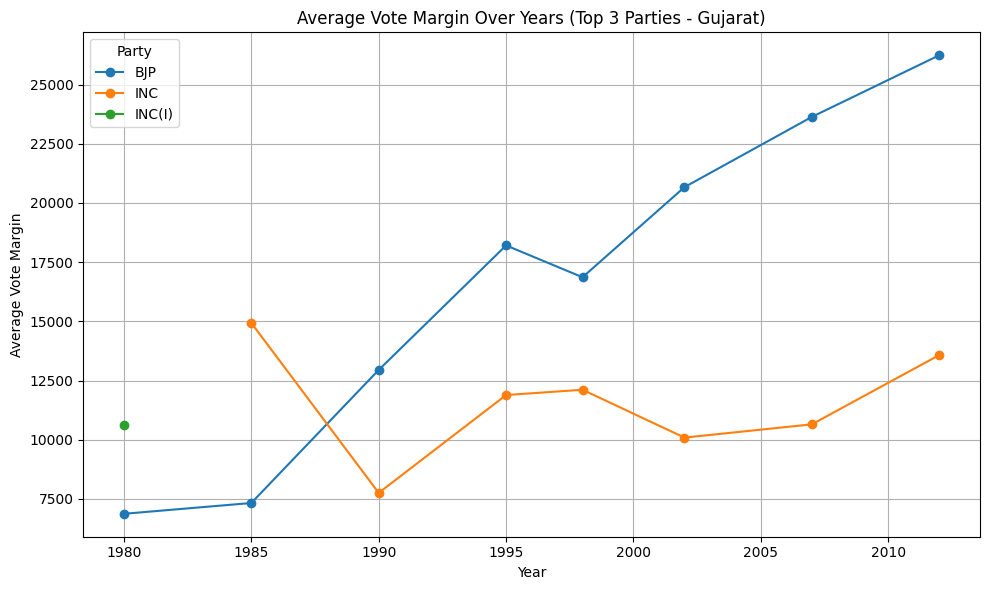

Outlier years based on vote margin:
Empty DataFrame
Columns: [year, partyabbre_winner, vote_margin]
Index: []


In [24]:
vidhan_df = vidhan_df.dropna(subset=['totvotpoll', 'electors'])

# Step a & b: Calculate vote share percentage for each candidate
vidhan_df['vote_share_percent'] = (vidhan_df['totvotpoll'] / vidhan_df['electors']) * 100

# Step c: Filter for Gujarat
gujarat_df = vidhan_df[vidhan_df['st_name'] == 'Gujarat']

# Step d & e: Rank candidates within each (year, constituency)
gujarat_df['rank'] = gujarat_df.groupby(['year', 'ac_no'])['totvotpoll'].rank(method='first', ascending=False)

# Step f: Identify winners and runners-up
winners = gujarat_df[gujarat_df['rank'] == 1]
runners_up = gujarat_df[gujarat_df['rank'] == 2]

# Step g: Calculate vote margin
merged = pd.merge(
    winners,
    runners_up,
    on=['year', 'ac_no'],
    suffixes=('_winner', '_runnerup')
)
merged['vote_margin'] = merged['totvotpoll_winner'] - merged['totvotpoll_runnerup']

# Step h: Get top 3 winning parties in Gujarat
top3_parties = winners['partyabbre'].value_counts().head(3).index.tolist()
top_margin_df = merged[merged['partyabbre_winner'].isin(top3_parties)]

# Step i: Plot histogram of vote margins
plt.figure(figsize=(10, 5))
sns.histplot(top_margin_df['vote_margin'], bins=30, kde=True, color='orange')
plt.title("Distribution of Vote Margins (Top 3 Parties) - Gujarat")
plt.xlabel("Vote Margin")
plt.ylabel("Number of Constituencies")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Step j: Average vote margin per year per party
avg_margin_year_party = top_margin_df.groupby(['year', 'partyabbre_winner'])['vote_margin'].mean().reset_index()

plt.figure(figsize=(10, 6))
for party in top3_parties:
    party_data = avg_margin_year_party[avg_margin_year_party['partyabbre_winner'] == party]
    plt.plot(party_data['year'], party_data['vote_margin'], marker='o', label=party)

plt.title("Average Vote Margin Over Years (Top 3 Parties - Gujarat)")
plt.xlabel("Year")
plt.ylabel("Average Vote Margin")
plt.grid(True)
plt.legend(title="Party")
plt.tight_layout()
plt.show()

# Step k: Identify outlier years using IQR
q1 = avg_margin_year_party['vote_margin'].quantile(0.25)
q3 = avg_margin_year_party['vote_margin'].quantile(0.75)
iqr = q3 - q1

outliers = avg_margin_year_party[
    (avg_margin_year_party['vote_margin'] < q1 - 1.5 * iqr) |
    (avg_margin_year_party['vote_margin'] > q3 + 1.5 * iqr)
]

print("Outlier years based on vote margin:")
print(outliers[['year', 'partyabbre_winner', 'vote_margin']])

###Observation
### i. Vote Margin Patterns
The majority of vote margins fall between 10,000–20,000 votes. Larger margins above 50,000 are rare. This shows that most contests are closely fought, with only a few landslide wins.

---

### ii. What does the distribution of vote margins tell us about the competitiveness of elections in Gujarat?
The histogram shows a right-skewed distribution, where low margins are most frequent. This suggests high competitiveness, as many seats are won by relatively narrow vote gaps.

---

### iii. Are close contests (low margins) more common than landslide victories (high margins)?
Yes — close contests are far more common. The majority of seats were won with less than 25,000 votes difference, indicating tight battles between candidates in most constituencies.

---

### iv. Party-wise Comparison

### v. Among the top 3 parties in Gujarat, which party tends to win by the largest average margin?
BJP has the highest average vote margin across multiple election years, especially after 2002. It shows that BJP's victories are not just frequent but also more decisive.

### vi. How do vote margins differ between these parties across different election years?
- BJP: Shows a steady rise in margin, peaking during early 2000s and maintaining higher levels.
- INC: Had strong margins before 1990, but they declined post-2000s.
- INC(I): Recorded a large average margin only in 1980, then disappeared from later years.

---

### vii. Trend Over Time

### viii. Has the average vote margin increased, decreased, or remained stable over the years?
The trend indicates that average vote margins have generally increased, particularly for the leading party (BJP). This suggests growing voter consolidation behind the winners.

### ix. What might explain these trends—changing voter loyalty, stronger opposition, or shifting party dominance?
Several possible reasons:
- Shifting dominance from INC to BJP after 1990
- Stronger party loyalty among BJP voters
- Fragmentation or weakening of the opposition
- Successful campaigning or strong leadership projection by dominant parties

---

### x. Outlier Analysis

### xi. Which years were identified as outliers in vote margin trends?
According to the IQR-based method:
No years were detected as outliers meaning average margins stayed within expected ranges.

### xii. What political or social events might explain why the margins were unusually high or low in those years?
Since no statistical outliers were found, there were no margin shocks large enough to stand out. However, you might still explore:
- 2002 post-crisis consolidation behind BJP
- 1985 INC surge after national sympathy wave
- Any voter swings due to reforms, alliances, or major national trends

---

## xiii. Competitiveness

### xiv. Based on vote margins and their changes over time, would you say Gujarat elections are becoming more or less competitive?
- Overall, Gujarat elections have become less competitive in many constituencies due to larger average margins for dominant parties like BJP.
- However, some areas remain battlegrounds, keeping pockets of competitiveness alive.

---




## 18.State-Level Voter Turnout and Constituency Analysis

In this section, I analyze the voter turnout percentage and constituency distribution across Indian states in Vidhan Sabha elections.  
This helps to understand both voter participation and seat allocation at the state level.



/tmp/ipython-input-25-1112434384.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=turnout_sorted, y='st_name', x='voter_turnout_percent', palette='Blues_d')


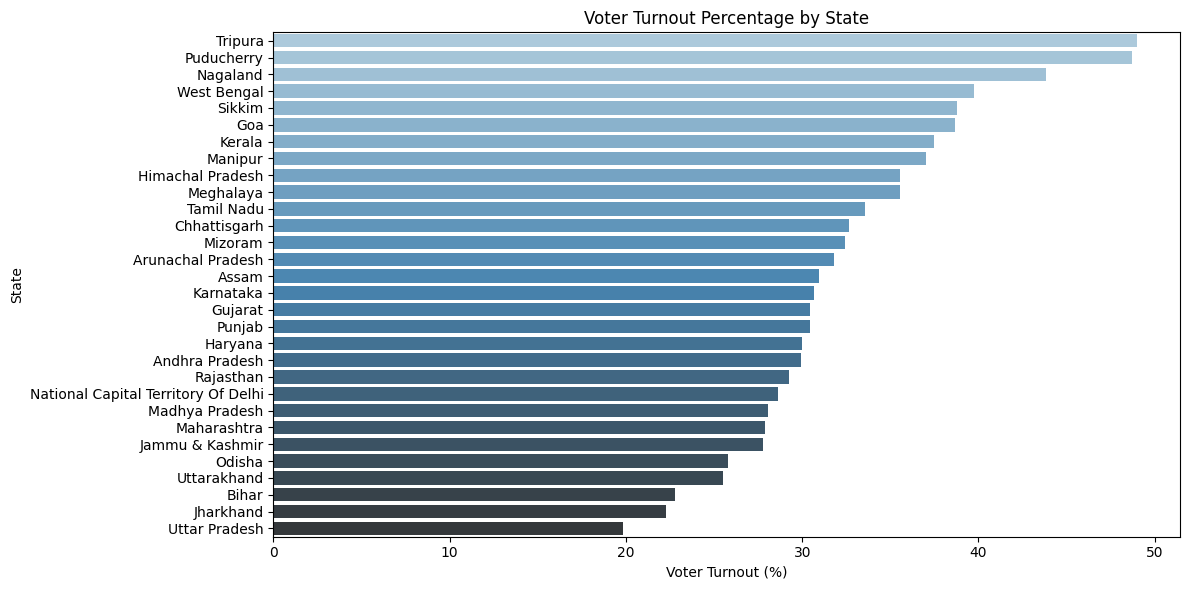

/tmp/ipython-input-25-1112434384.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=constituency_sorted, y='st_name', x='num_constituencies', palette='Greens_d')


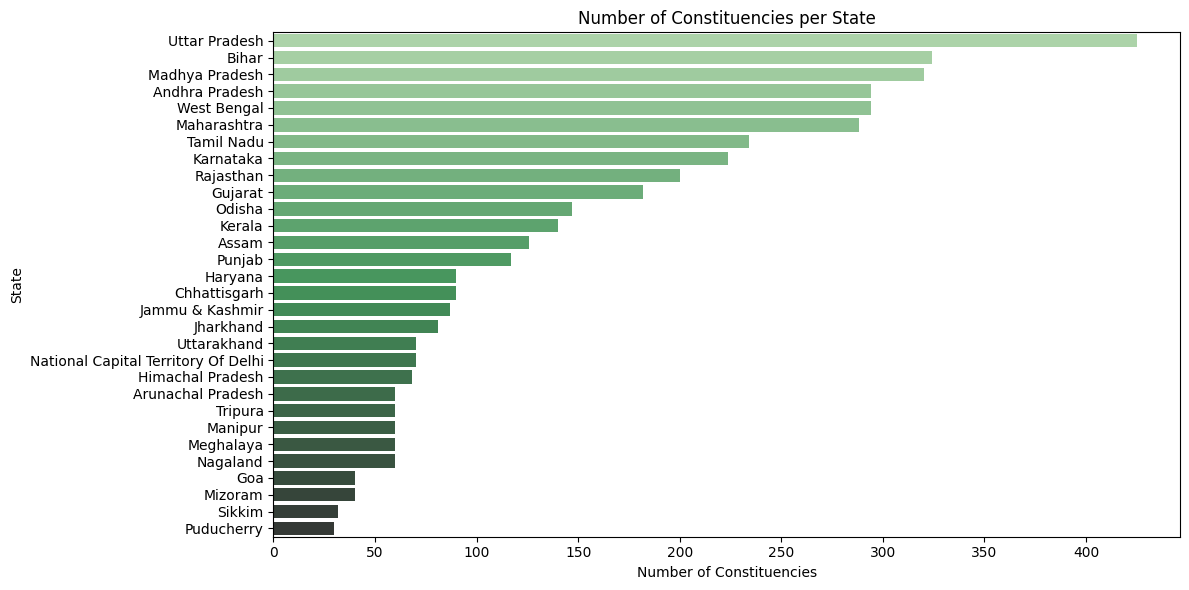

In [25]:
# Step a: Calculate total votes polled and total electors for each constituency
constituency_level = (
    vidhan_df.groupby(['st_name', 'year', 'ac_no'])[['totvotpoll', 'electors']]
    .max()
    .reset_index()
)

# Step b: Aggregate totals to the state level
state_level = (
    constituency_level.groupby('st_name')[['totvotpoll', 'electors']]
    .sum()
    .reset_index()
)

# Step c & d: Calculate voter turnout percentage for each state
state_level['voter_turnout_percent'] = (state_level['totvotpoll'] / state_level['electors']) * 100

# Step e: Sort states by voter turnout
turnout_sorted = state_level.sort_values(by='voter_turnout_percent', ascending=False)

# Step f: Count how many unique constituencies were contested in each state
constituency_counts = (
    vidhan_df.groupby('st_name')['ac_no']
    .nunique()
    .reset_index(name='num_constituencies')
)

# Step g: Sort and display states by number of constituencies
constituency_sorted = constituency_counts.sort_values(by='num_constituencies', ascending=False)

# Step h-i: Plot voter turnout percentage by state
plt.figure(figsize=(12, 6))
sns.barplot(data=turnout_sorted, y='st_name', x='voter_turnout_percent', palette='Blues_d')
plt.title("Voter Turnout Percentage by State")
plt.xlabel("Voter Turnout (%)")
plt.ylabel("State")
plt.tight_layout()
plt.show()

# Step h-ii: Plot number of constituencies per state
plt.figure(figsize=(12, 6))
sns.barplot(data=constituency_sorted, y='st_name', x='num_constituencies', palette='Greens_d')
plt.title("Number of Constituencies per State")
plt.xlabel("Number of Constituencies")
plt.ylabel("State")
plt.tight_layout()
plt.show()


###Observation
- Plot 1

States like Tripura, Nagaland, and Sikkim had many people go out and vote — that’s a good sign of public interest.

Big states like Uttar Pradesh and Bihar had fewer people voting, even though they have a lot of voters.

- Plot 2

Uttar Pradesh has the most constituencies, meaning it sends more leaders to the assembly because it has more people.

Sikkim, Puducherry, and Mizoram have very few constituencies, which makes sense since they’re smaller places.

## 19. Party-wise Candidate Gender Distribution

This section examines how different political parties field male, female, and unknown-gender candidates in Vidhan Sabha elections.  
It helps to understand gender representation in Indian politics across parties.


,Gender,Total_Candidates,Total_Winners,Win_Rate (%)
0,F,3648,85.0,2.330044
1,M,68885,834.0,1.210714
2,O,6,0.0,0.000000
3,U,542,0.0,0.000000


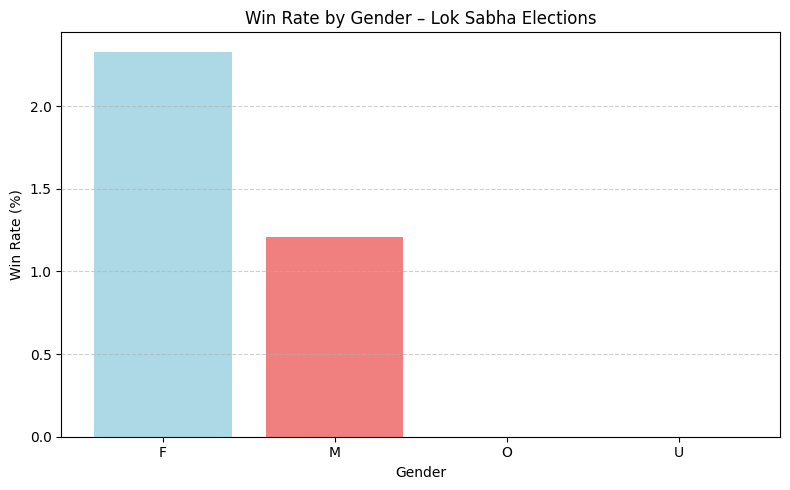

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Step a: Count number of candidates by gender
gender_counts = (
    lok_df['cand_sex']
    .value_counts(dropna=False)
    .rename_axis('Gender')
    .reset_index(name='Total_Candidates')
)

# Step b: Identify winners (highest vote-getter per (year, pc_no))
winner_indices = (
    lok_df.dropna(subset=['totvotpoll'])
    .groupby(['year', 'pc_no'])['totvotpoll']
    .idxmax()
)
winners_df = lok_df.loc[winner_indices]

# Step c: Count number of winners by gender
winner_gender_counts = (
    winners_df['cand_sex']
    .value_counts(dropna=False)
    .rename_axis('Gender')
    .reset_index(name='Total_Winners')
)

# Step d: Merge the two DataFrames
comparison_df = pd.merge(gender_counts, winner_gender_counts, on='Gender', how='outer')

# Step e: Fill NaNs with 0 (in case some genders had no winners or candidates)
comparison_df[['Total_Candidates', 'Total_Winners']] = comparison_df[['Total_Candidates', 'Total_Winners']].fillna(0)

# Step f: Calculate win rate
comparison_df['Win_Rate (%)'] = (comparison_df['Total_Winners'] / comparison_df['Total_Candidates']) * 100

# Step g: Display sorted results
comparison_df = comparison_df.sort_values(by='Win_Rate (%)', ascending=False).reset_index(drop=True)
display(comparison_df)

# Step h: Plot win rate
plt.figure(figsize=(8, 5))
plt.bar(comparison_df['Gender'].astype(str), comparison_df['Win_Rate (%)'], color=['lightblue', 'lightcoral', 'gray'])
plt.title("Win Rate by Gender – Lok Sabha Elections")
plt.ylabel("Win Rate (%)")
plt.xlabel("Gender")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


###Observation

### i. Participation Patterns

1. Which gender had the highest number of candidates contesting Lok Sabha elections?
   - Male candidates had the highest number of participants.

2. Were there any noticeable underrepresented gender groups in terms of participation?
   - Yes, female and especially "Other/Unknown" gender groups were underrepresented.

---

### ii. Winning Performance

1. Which gender secured the highest number of seats overall?
   - Male candidates secured the highest number of winning seats.

2. Were there any gender groups with very few or no winners?
   - Yes, candidates identified as "Other" or "Unknown" had very few or no winners.

---

### iii. Win Rate Evaluation

1. Which gender had the highest win rate (success percentage)?
   - Female candidates had the highest win rate among all gender groups.

2. Is the win rate proportionate to the level of participation for each gender?
   - No, even though more male candidates contested, female candidates had a better success ratio compared to their participation level.

---

### iv. Equity and Representation

1. Does the data suggest any gender imbalance in electoral outcomes?
   - Yes, the data shows a clear gender imbalance. Most candidates and winners were male, while women and others had lower participation and outcomes.

2. Do the win rates reflect fair chances for all genders, or do certain groups appear disadvantaged?
   - The win rates suggest that certain groups, especially non-male candidates, are disadvantaged, possibly due to fewer opportunities to contest.

---

### v. Critical Reflection

1. Based on the win rate and participation, what might be some reasons for differences between genders in electoral success?
   - Some reasons could include fewer party nominations for women and others, lack of financial or social support, and existing biases in politics and voter behavior.

2. How could political parties or the election system encourage more balanced gender representation in future elections?
   - They can introduce candidate quotas, training programs for underrepresented genders, increase visibility of female and diverse leaders, and raise public awareness for inclusive representation.


## 20. Visual Analysis of Gender-Based Participation and Performance – Lok Sabha

I use bar charts to visually compare:
1. The number of candidates by gender  
2. The number of winners by gender  
3. The win rate by gender  
This helps to understand gender dynamics in parliamentary elections.


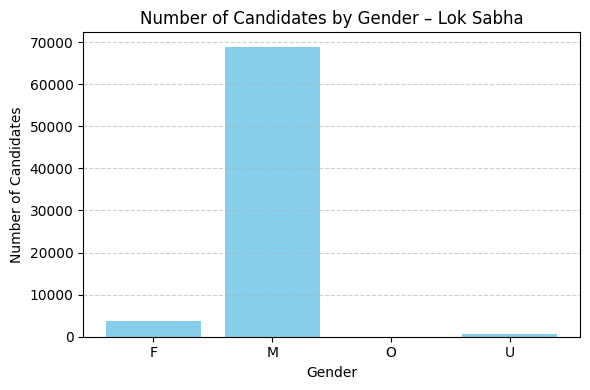

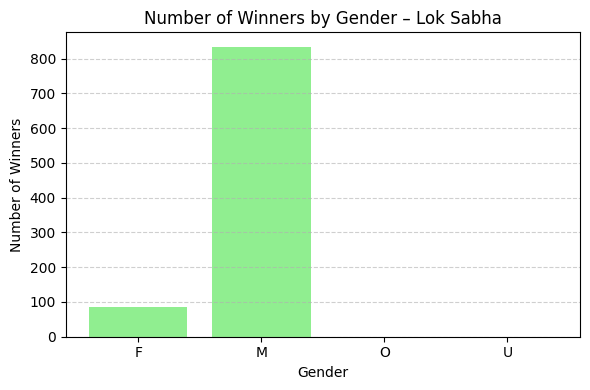

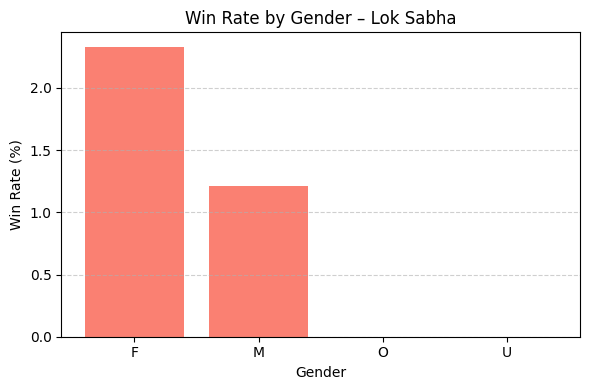

In [27]:
# Step a: Plot 1 – Number of Candidates by Gender
# Using 'Total_Candidates' column from gender comparison table
plt.figure(figsize=(6, 4))
plt.bar(comparison_df['Gender'], comparison_df['Total_Candidates'], color='skyblue')
plt.title("Number of Candidates by Gender – Lok Sabha")
plt.xlabel("Gender")
plt.ylabel("Number of Candidates")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Step b: Plot 2 – Number of Winners by Gender
# Using 'Total_Winners' column from gender comparison table
plt.figure(figsize=(6, 4))
plt.bar(comparison_df['Gender'], comparison_df['Total_Winners'], color='lightgreen')
plt.title("Number of Winners by Gender – Lok Sabha")
plt.xlabel("Gender")
plt.ylabel("Number of Winners")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Step c: Plot 3 – Win Rate by Gender
# Using 'Win_Rate (%)' column from gender comparison table
plt.figure(figsize=(6, 4))
plt.bar(comparison_df['Gender'], comparison_df['Win_Rate (%)'], color='salmon')
plt.title("Win Rate by Gender – Lok Sabha")
plt.xlabel("Gender")
plt.ylabel("Win Rate (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



###Observations

1. Which gender had the highest participation?  
   - Male candidates had the highest participation by a large margin.

2. Which gender wins more often?  
   - Males won the most seats overall, but females had a higher win rate when they did contest.

3. Are there any surprising trends or imbalances?  
   - Yes. Female candidates are fewer, but they win more often compared to their numbers. Candidates listed as "Other" or "Unspecified" had no winners at all, showing clear underrepresentation.

- Are win rates proportionate to participation?  
  - No. Male candidates dominate in numbers but have a lower win rate. Female candidates have fewer opportunities but are more likely to win, showing a gap between opportunity and outcome.

- What does this imply?  
  - The system may not offer equal chances to all genders. Female candidates perform well when given the chance, suggesting more balanced participation could improve fairness and representation.

##21.Seats Won by Top 5 Parties – Lok Sabha

This section explores how India's top 5 political parties have performed in Lok Sabha elections over time, measured by the number of seats won per year.


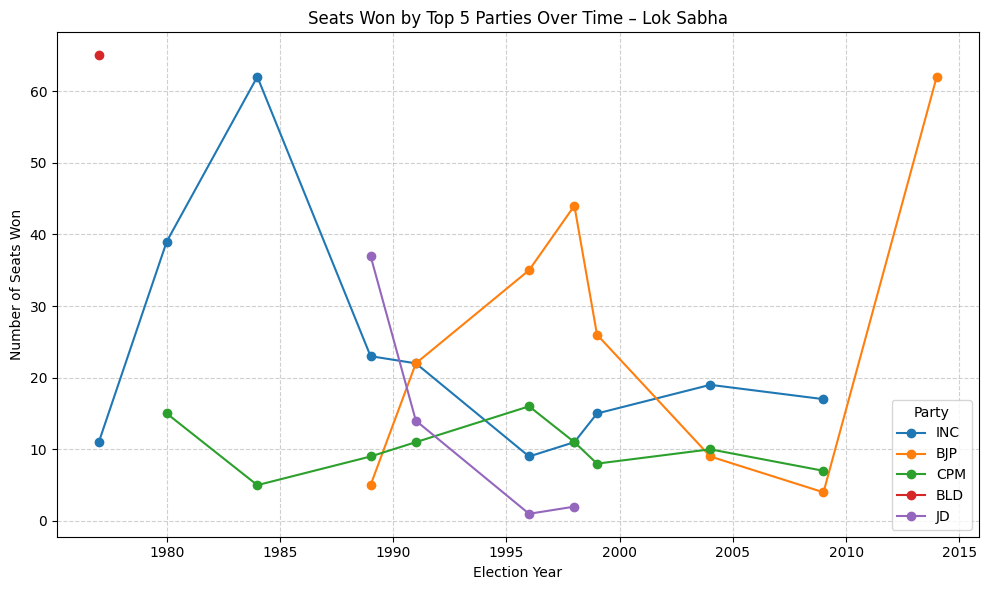

In [28]:
# Step a-i: Identify winning candidates in each constituency and year
winner_indices = (
    lok_df.dropna(subset=['totvotpoll'])
    .groupby(['year', 'pc_no'])['totvotpoll']
    .idxmax()
)
winners_df = lok_df.loc[winner_indices]

# Step a-ii: Count seats won per party per year
seats_per_party_year = (
    winners_df.groupby(['year', 'partyabbre'])
    .size()
    .reset_index(name='seats_won')
)

# Step a-iii: Find top 5 parties based on total seats won across all years
top_5_parties = (
    seats_per_party_year.groupby('partyabbre')['seats_won']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

# Step a-iv: Filter for only top 5 parties
top5_seats = seats_per_party_year[seats_per_party_year['partyabbre'].isin(top_5_parties)]

# Step a-v: Plot line chart for seat trends over time
plt.figure(figsize=(10, 6))
for party in top_5_parties:
    party_data = top5_seats[top5_seats['partyabbre'] == party]
    plt.plot(party_data['year'], party_data['seats_won'], marker='o', label=party)

plt.title("Seats Won by Top 5 Parties Over Time – Lok Sabha")
plt.xlabel("Election Year")
plt.ylabel("Number of Seats Won")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Party")
plt.tight_layout()
plt.show()


###Observation
Brief Description

1.Which party has been consistently dominant?

The Indian National Congress (INC) was the dominant party, especially before the 1990s. It won the most seats in earlier elections, with a peak around 1985.

2.Are there any major changes or trends in party performance over time?

Yes. After the mid-1980s, INC’s dominance began to fade, while the Bharatiya Janata Party (BJP) steadily grew stronger. By 2014, BJP had become the leading party in terms of seats won.

3.Does any party show a significant rise or decline in influence?

BJP shows a clear rise, especially from 1999 onward. On the other hand, INC shows a major decline after its peak in the 1980s. Smaller parties like JD and BLD had brief peaks but declined or disappeared from national relevance later.

This analysis gives a clear view of how party strengths have shifted over time in Lok Sabha elections. It shows how national politics moved from a Congress-dominated phase to a more competitive, BJP-led landscape in recent years. It also highlights how some parties rose quickly but then faded, reflecting changes in public support and political alliances over time.

##22. Vote Share Trend of Top 5 Parties – Lok Sabha

In this section, I analyze how the vote share of the top 5 national parties has changed over time in Lok Sabha elections.

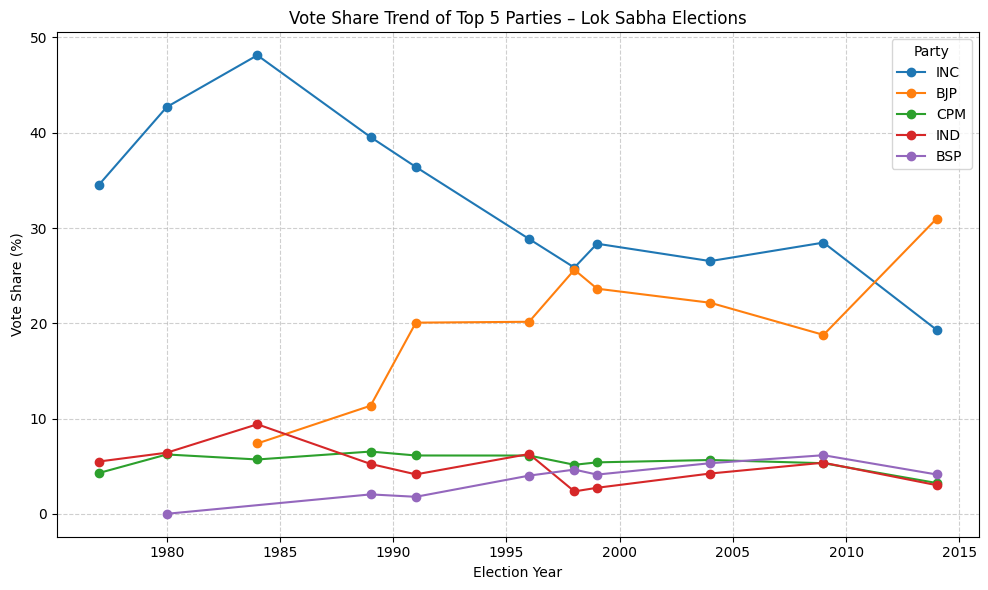

In [29]:
# Step a: Calculate total votes received by each party per year
party_votes_year = (
    lok_df.groupby(['year', 'partyabbre'])['totvotpoll']
    .sum()
    .reset_index(name='party_votes')
)

# Step b: Calculate total votes cast per year
total_votes_year = (
    lok_df.groupby('year')['totvotpoll']
    .sum()
    .reset_index(name='total_votes')
)

# Step c & d: Merge and compute vote share percentage
vote_share_df = pd.merge(party_votes_year, total_votes_year, on='year')
vote_share_df['vote_share_percent'] = (vote_share_df['party_votes'] / vote_share_df['total_votes']) * 100

# Step e: Find top 5 parties by total votes across all years
top5_parties = (
    vote_share_df.groupby('partyabbre')['party_votes']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

# Step f: Filter only top 5 parties
top5_vote_share_df = vote_share_df[vote_share_df['partyabbre'].isin(top5_parties)]

# Step g: Plot vote share trends over time for top 5 parties
plt.figure(figsize=(10, 6))
for party in top5_parties:
    party_data = top5_vote_share_df[top5_vote_share_df['partyabbre'] == party]
    plt.plot(party_data['year'], party_data['vote_share_percent'], marker='o', label=party)

plt.title("Vote Share Trend of Top 5 Parties – Lok Sabha Elections")
plt.xlabel("Election Year")
plt.ylabel("Vote Share (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Party')
plt.tight_layout()
plt.show()


###Observation

1.Which party has gained or lost vote share over time?

- The BJP has clearly gained vote share over time, especially from the late 1980s to 2014, with sharp rises around 1998 and again in 2014.

- The INC has steadily lost vote share since its peak in 1984, showing a long-term decline.

- BSP and IND show small fluctuations, while CPM has slightly declined.

2.Are there any crossover points or major shifts in political support?

- Yes. Around 1991, BJP overtook CPM in vote share.

- Around 1998, BJP’s vote share crossed over INC’s, marking a major shift in national political dominance.

- In 2014, BJP surged again, widening the gap with INC significantly.

3.Does any party maintain a steady vote base?

- The CPM has maintained a relatively stable vote share across the years, with only minor ups and downs. It didn’t grow much, but it also didn’t collapse like some others.

##23.Gini Coefficient of Vote Distribution – Lok Sabha

The Gini coefficient measures how unequally votes are distributed among all candidates.  
A Gini of 0 means perfect equality (all candidates get equal votes), and a Gini of 1 means perfect inequality (one candidate gets all votes).

 Overall Gini Coefficient (all years combined): 0.8173


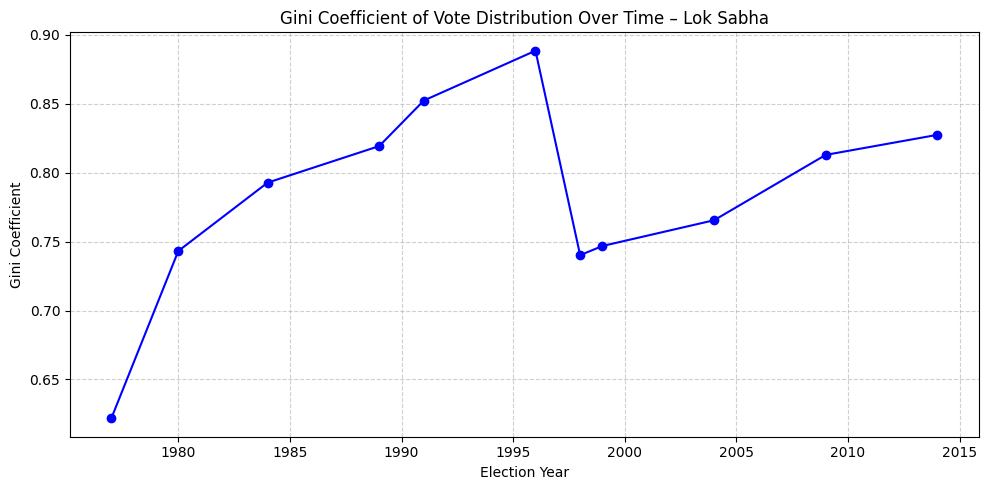

In [30]:
# Step a: Define function to calculate Gini coefficient
def gini_coefficient(values):
    values = np.array(values)
    values = values[~np.isnan(values)]  # Remove NaNs
    if len(values) == 0:
        return np.nan
    values_sorted = np.sort(values)
    n = len(values_sorted)
    cumulative = np.cumsum(values_sorted)
    gini = (2 * np.sum((np.arange(1, n + 1) * values_sorted))) / (n * np.sum(values_sorted)) - (n + 1) / n
    return gini

# Step b: Calculate overall Gini coefficient across all candidates' votes
overall_gini = gini_coefficient(lok_df['totvotpoll'])
print(" Overall Gini Coefficient (all years combined):", round(overall_gini, 4))

# Step c: Compute Gini coefficient for each election year
yearly_gini = (
    lok_df.groupby('year')['totvotpoll']
    .apply(gini_coefficient)
    .reset_index(name='gini')
)

# Step c: Compute Gini coefficient for each election year
yearly_gini = (
    lok_df.groupby('year')['totvotpoll']
    .apply(gini_coefficient)
    .reset_index(name='gini')
)

# Step d: Plot Gini coefficient over time
plt.figure(figsize=(10, 5))
plt.plot(yearly_gini['year'], yearly_gini['gini'], marker='o', linestyle='-', color='blue')
plt.title("Gini Coefficient of Vote Distribution Over Time – Lok Sabha")
plt.xlabel("Election Year")
plt.ylabel("Gini Coefficient")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


###Observation
### i. Understanding the Gini Trend

1. What does the Gini coefficient tell us about vote distribution among candidates in Lok Sabha elections?  
   - It measures how unevenly votes are spread across all candidates. A higher Gini means a few candidates got most of the votes. A lower Gini means votes were shared more evenly.

2. How do high and low Gini values relate to political competition?  
   - High Gini means less competition, as a few candidates dominate. Low Gini means more competition, with many candidates getting meaningful vote shares.

---

### ii. Historical Events and Gini Patterns

1. Why was the Gini coefficient lower in 1977? What political or social factors might have influenced this?  
   - The Emergency just ended in 1977. Voters were angry and many candidates, including new ones, gained support. This led to more equal vote distribution and a lower Gini value.

2. What could explain the sharp rise in vote concentration between 1980 and 1996?  
   - The Congress party regained power and was very strong during this period. That led to more votes going to fewer major parties, raising the Gini coefficient.

---

### iii. Sharp Changes in Vote Patterns

1. In 1998, there was a sudden drop in the Gini coefficient. What might have caused this shift toward more fragmented voting?  
   - Many regional parties grew stronger, and independents also gained attention. This spread the votes more widely across candidates.

2. How does this reflect the entry or rise of regional parties or independents?  
   - It shows that national dominance was being challenged. Regional parties started winning votes locally, making the system more competitive and diverse.

---

### iv. Bipolar Politics and Vote Consolidation

1. Between 1999 and 2014, the Gini coefficient steadily rose again. What does this suggest about the nature of electoral competition during this period?  
   - This means votes started concentrating again. Fewer parties got most of the votes, suggesting that elections became more focused on major rivals like BJP and Congress.

2. How might the growth of national coalitions (e.g., NDA, UPA) have impacted vote concentration?  
   - Coalitions helped big parties gather votes under one umbrella. This reduced voter spread and increased the share of the leading few, causing the Gini to rise.

---

### v. Long-Term Trends and Democratic Health

1. Based on the full trend from 1977 to 2019, do you think Indian Lok Sabha elections are becoming more or less competitive?  
   - Elections were more competitive in the late 1970s and late 1990s when the Gini was low. But overall, the trend shows a rise in vote concentration, meaning elections have become less competitive over time.

2. What are the pros and cons of high vote concentration in a democracy?  
   - Pros: It can bring stability and clearer majorities in parliament.  
   - Cons: It may reduce diversity of voices and discourage smaller parties or independent candidates.

---

### vi. Final conclusion

The Gini trend closely follows Indian political history. When big parties like Congress or BJP dominated, the Gini rose. When voters supported many small or regional parties, the Gini dropped. This shows how vote inequality changes with political events, leadership shifts, and the structure of the election system. Understanding this can help us see whether power is becoming too centralized or if democracy is giving space to more voices.



##24.Lorenz Curve of Vote Distribution – Lok Sabha

The Lorenz Curve is a graphical representation of inequality in vote distribution.  
It shows how votes are shared among all candidates in Lok Sabha elections.

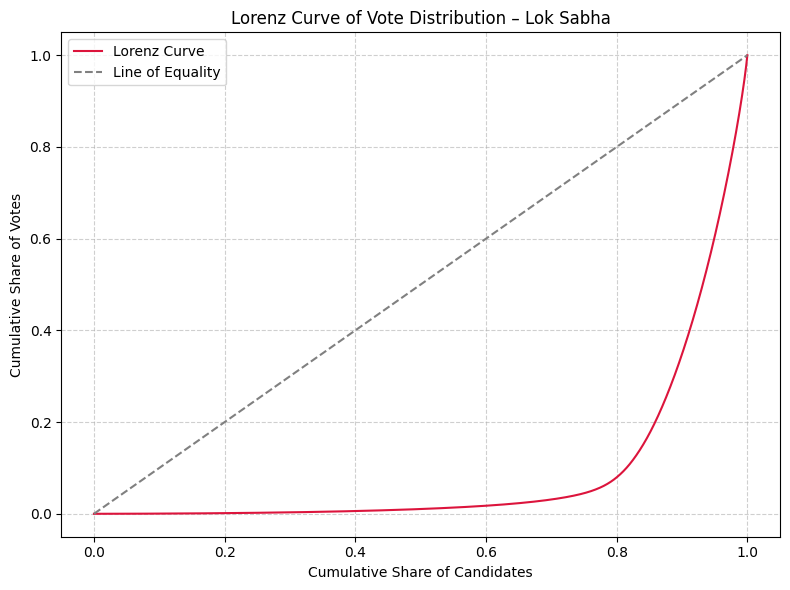

In [31]:
# Step a: Filter and sort vote data (non-zero votes only)
votes = lok_df['totvotpoll'].dropna()
votes = votes[votes > 0].sort_values().values  # Sorted in ascending order

# Step b: Compute cumulative percentages

# i. X-axis: Candidates (cumulative %)
n = len(votes)
x = np.arange(1, n + 1) / n  # Percent of candidates

# ii. Y-axis: Votes (cumulative % of total votes)
cumulative_votes = np.cumsum(votes)
y = cumulative_votes / cumulative_votes[-1]  # Normalize to 1

# Step c: Plot Lorenz Curve
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Lorenz Curve', color='crimson')
plt.plot([0, 1], [0, 1], linestyle='--', label='Line of Equality', color='gray')  # Line of Equality

plt.title("Lorenz Curve of Vote Distribution – Lok Sabha")
plt.xlabel("Cumulative Share of Candidates")
plt.ylabel("Cumulative Share of Votes")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


###Observation

### i. Understanding the Shape of the Curve

1. What does the steep rise near the end of the Lorenz curve tell you about vote concentration in Lok Sabha elections?  
   - It shows that a few candidates got most of the votes. This means voting is highly concentrated toward a small group.

2. Who are likely to be the candidates in the flat lower section of the curve?  
   - These are candidates who received very few or almost no votes. They are often independents or from small parties.

---

### ii. Measuring Inequality

1. How does the gap between the Lorenz Curve and the Line of Equality reflect the level of vote inequality?  
   - A bigger gap means votes are shared very unequally. It shows that some candidates got most of the votes, while many others got very little.

2. Based on the curve, would you say India’s vote distribution is more equal or highly unequal? Why?  
   - The distribution is highly unequal because the curve is far away from the line of equality. Only a few candidates gather most of the total votes.

---

### iii. Electoral System Effects

1. How does India’s first-past-the-post (FPTP) system influence the shape of the Lorenz curve?  
   - FPTP leads to vote concentration because only the top candidate wins. This pushes voters to support major parties, making the curve steeper at the end.

2. Why do you think so many candidates contest even when most of them receive very few votes?  
   - Some contest to represent specific issues, gain attention, or prepare for future elections. Others may run even with low chances to show presence in politics.

---

### iv. Implications of Vote Concentration

1. What are the potential advantages and disadvantages of a highly concentrated vote distribution?  
   - Advantage: It can lead to strong governments and fewer hung parliaments.  
   - Disadvantage: It limits representation for smaller voices and may reduce fairness in elections.

2. Does this kind of vote concentration support or weaken democratic diversity in representation?  
   - It weakens diversity. When a few candidates win most votes, smaller groups or new parties struggle to get represented.

---

### v. Final Conclusion

The Lorenz curve clearly shows that most candidates get very few votes, while a small number get most of them. This may be because of the voting system and how people focus on major parties. While this makes elections simpler and winners clearer, it also creates challenges for fairness and diversity in democratic representation.


##25.Skewness and Kurtosis of Vote Share – Lok Sabha

In this section, I use two statistical measures— skewness and kurtosis to understand the shape of the vote share distribution across all candidates.

In [32]:
# Step a & b: Calculate vote share % while avoiding division by zero
lok_df['vote_share_percent'] = np.where(
    lok_df['electors'] > 0,
    (lok_df['totvotpoll'] / lok_df['electors']) * 100,
    np.nan
)

# Step c: Remove invalid entries (missing or over 100%)
valid_vote_share = lok_df['vote_share_percent']
valid_vote_share = valid_vote_share[(valid_vote_share.notna()) & (valid_vote_share <= 100)]

# Import skew and kurtosis from scipy.stats
from scipy.stats import skew, kurtosis

# Step d: Compute skewness – measure of symmetry
vote_share_skewness = skew(valid_vote_share)
print("Skewness of vote share distribution:", round(vote_share_skewness, 4))

# Step e: Compute kurtosis – measure of peakedness
vote_share_kurtosis = kurtosis(valid_vote_share)
print("Kurtosis of vote share distribution:", round(vote_share_kurtosis, 4))

Skewness of vote share distribution: 2.2187
Kurtosis of vote share distribution: 4.0478


###Observation

### i. Understanding Skewness

1. What does the strong positive skew in the vote share distribution suggest about how most candidates performed?  
   - Most candidates received a small share of the votes, while a few gained very high shares. This means the majority of candidates underperformed, and vote support was uneven.

2. Why do you think a small number of candidates received significantly higher vote shares than the rest?  
   - Strong candidates backed by major parties usually have more visibility, resources, and voter loyalty. That helps them get a much higher share, leaving others behind.

---

### ii. Impact of Political Landscape

1. How does the presence of major political parties vs. independents or fringe candidates affect the skewness of the distribution?  
   - Major parties dominate elections, which pushes the skew to the right. Smaller players often get very few votes, widening the gap in vote share between candidates.

2. Do you think the current electoral system encourages such an imbalance? Why or why not?  
   - Yes, India’s first-past-the-post system rewards the candidate with the most votes, even if others get a decent share. This encourages power to stay with a few strong parties, and discourages smaller or independent candidates.

---

### iii. Kurtosis Interpretation

1. The distribution is leptokurtic (kurtosis > 3). What does this tell you about vote share variation among candidates?  
   - It means the vote share has extreme values — a few very high or very low scores — and less in the middle. There's a sharp divide between winners and weak performers.

2. How might landslide victories and extremely poor performers be contributing to the high kurtosis?  
   - Candidates who win by huge margins stretch the right end of the curve, while many others who get almost no votes flatten the left end. This makes the distribution more peaked and heavy-tailed.

---

### iv. Implications for Electoral Representation

1. Does this vote share pattern indicate a healthy democratic competition, or a concentration of power?  
   - It points to a concentration of power. A few parties dominate outcomes, while many candidates don’t stand a real chance. That’s not very balanced for a representative democracy.

2. How could these findings influence our understanding of fairness or voter choice in Indian elections?  
   - They show that while voters do have many choices, effective competition is limited. Fairness in elections isn’t just about offering options — it’s about whether those options have a realistic shot. This raises important questions about equal opportunity in political representation.



##26.Skewness & Kurtosis Over Time – Lok Sabha

This section analyzes how the shape of vote share distribution has changed over time using:

- Skewness – measures asymmetry of distribution
- Kurtosis – measures peakness and presence of outliers

In [33]:
# Step a: Group data by election year and prepare summary list
summary_stats = []

for year, group in lok_df.groupby('year'):
    # Step b & c: Compute skewness and kurtosis for valid vote shares
    vote_share = np.where(
        group['electors'] > 0,
        (group['totvotpoll'] / group['electors']) * 100,
        np.nan
    )
    vote_share = vote_share[~np.isnan(vote_share)]
    vote_share = vote_share[vote_share <= 100]  # Filter out unrealistic values

    year_skewness = skew(vote_share)
    year_kurtosis = kurtosis(vote_share)

    # Step d: Append year-wise stats to the summary table
    summary_stats.append({
        'year': year,
        'Skewness': year_skewness,
        'Kurtosis': year_kurtosis
    })

# Create DataFrame of results
vote_dist_summary = pd.DataFrame(summary_stats)
display(vote_dist_summary)

,year,Skewness,Kurtosis
0,1977,0.869836,-0.487988
1,1980,1.733725,1.986911
2,1984,1.914409,2.355135
3,1989,2.136984,3.499113
4,1991,2.810178,7.671801
5,1996,3.636894,13.781332
6,1998,1.389376,0.551309
7,1999,1.446932,0.728694
8,2004,1.884250,2.647415
9,2009,2.530822,5.828738


###Observation

### i. Historical Trends and Interpretation

1. Which election year showed the most balanced vote distribution? What political or historical context might explain this?  
   - The year 1977 had the lowest skewness (0.87) and negative kurtosis (–0.48), indicating the most balanced vote distribution. This came just after the Emergency, when public anger led to widespread support for many non-Congress candidates, making the election more competitive and evenly split.

2. Which year had the highest skewness and kurtosis? What does this say about electoral competition and dominance?  
   - In 1996, skewness was 3.64 and kurtosis was 13.78 — the highest values in the dataset. This points to a sharp imbalance, where a few candidates got very high vote shares while most others got very little. It reflects reduced competition and vote concentration around dominant players.

---

### ii. Systemic Effects

1. How does India’s first-past-the-post (FPTP) system influence vote distribution, based on the skewness observed across years?  
   - FPTP encourages strategic voting and concentrates votes around front-runners. This creates strong positive skew because a few candidates win big while many others get very low support.

2. Do you think this system helps or hurts political diversity in elections? Use data trends to justify your answer.  
   - It hurts diversity. High skewness and kurtosis in many years show that a small number of candidates dominate. Smaller parties or independents often don’t get enough support to win, even if they have a notable vote share.

---

### iii. Shifts in Electoral Dynamics

1. What major shifts in voting patterns can you detect from 1977 to 2014? Identify at least one period where vote inequality increased or decreased significantly and explain why.  
   - From 1980 to 1996, vote inequality increased sharply, as seen in the rising skewness and kurtosis. This likely reflects Congress’s return to power and later the rise of BJP, both drawing strong vote shares.  
   - In 1998–1999, there was a noticeable drop in both values, pointing to a period of more fragmented and competitive politics.

2. What does the dip in skew and kurtosis in 1998–1999 suggest about the nature of those elections?  
   - These elections saw closer races and more parties receiving support. It suggests wider voter choice and less dominance, possibly due to coalition politics and rise of regional players.

---

### iv. Rise of Dominance or Diversity?

1. Do the more recent years (2009–2014) suggest a concentration of power in fewer parties or a return to balanced competition?  
   - The steady rise in skewness (2.5 in 2009, 2.5 in 2014) and kurtosis (~5.8 and 5.3) suggests increasing concentration. Power was consolidating in fewer hands, likely around BJP and Congress.

2. Is high kurtosis (e.g., in 1991 or 1996) always a bad sign? Or can it reflect political clarity and strong mandates?  
   - It’s not always bad. High kurtosis may show clear public support and strong mandates. But if it comes with low participation or limited competition, it can reflect inequality and low diversity.

---

### v. Critical Reflection

1. What does the combination of skewness and kurtosis tell us about representation and voter voice in Indian democracy?  
   - It tells us how votes are spread and whether voters have real options. High skew and kurtosis suggest limited choice or dominance by a few players, which can weaken true representation.

2. Based on this analysis, would you say electoral contests are becoming more competitive or more one-sided over time?  
   - Contests were more competitive in the late 1970s and late 1990s. But since 2004, skewness and kurtosis have risen again, showing that elections are becoming more one-sided, with votes going to fewer major parties.



##27.Party-wise Skewness & Kurtosis of Vote Share – Lok Sabha

This section evaluates how consistent or extreme each party’s vote share has been over the years.

In [34]:
# Step a: Total votes received by each party per year
party_votes = (
    lok_df.groupby(['year', 'partyabbre'])['totvotpoll']
    .sum()
    .reset_index(name='party_votes')
)

# Step b: Total votes polled per year
total_votes = (
    lok_df.groupby('year')['totvotpoll']
    .sum()
    .reset_index(name='total_votes')
)

# Step c: Merge and compute vote share %
vote_share = pd.merge(party_votes, total_votes, on='year')
vote_share['vote_share_percent'] = (vote_share['party_votes'] / vote_share['total_votes']) * 100

# Step d: Filter parties that participated in at least 3 elections
participation_count = vote_share['partyabbre'].value_counts()
eligible_parties = participation_count[participation_count >= 3].index.tolist()

filtered_vote_share = vote_share[vote_share['partyabbre'].isin(eligible_parties)]

# Step e: Compute skewness and kurtosis of vote share for each party
summary_list = []

for party in filtered_vote_share['partyabbre'].unique():
    party_data = filtered_vote_share[filtered_vote_share['partyabbre'] == party]['vote_share_percent']
    summary_list.append({
        'partyabbre': party,
        'Skewness': skew(party_data),
        'Kurtosis': kurtosis(party_data)
    })

party_vote_stats = pd.DataFrame(summary_list)

# Step f: Summary Table – Top 5 Right-Skewed & Bottom 5 Left-Skewed
# Sort by skewness
sorted_stats = party_vote_stats.sort_values(by='Skewness', ascending=False)

# Top 5 most right-skewed (occasional spikes)
print("Top 5 Right-Skewed Parties (few big spikes):")
display(sorted_stats.head(5))

# Bottom 5 most left-skewed (possibly declining or balanced)
print("Bottom 5 Left-Skewed Parties (steady/declining):")
display(sorted_stats.tail(5))


Top 5 Right-Skewed Parties (few big spikes):


,partyabbre,Skewness,Kurtosis
22,SSD,2.108498,3.223395
61,JP,1.778669,1.181883
71,ABJS,1.589929,0.862739
11,JKP,1.561140,1.392361
99,IUML,1.497920,0.247183


Bottom 5 Left-Skewed Parties (steady/declining):


,partyabbre,Skewness,Kurtosis
160,INLD,-0.982702,-0.772453
2,CPM,-1.145262,0.578997
14,MRP,-1.177393,-0.260929
21,SAD,-1.286697,1.907640
67,SP,-1.407391,1.033443


###Observation
### i. Right-Skewed Parties (One-time success stories)

1. Which parties showed high positive skewness, and what does this suggest about their electoral success pattern?  
   - SSD, JP, ABJS, JKP, and IUML had high positive skewness. This means these parties had one or two years where they got a big vote share, but were much weaker in other years.

2. Why might a party gain high vote share in only one year, but perform poorly in others?  
   - This can happen if the party was formed around a specific movement, leader, or issue that was only popular for a short time. It might also be due to a one-time alliance or local wave.

3. What does it mean for a party to be a "one-hit wonder" in electoral politics?  
   - It means the party did well in just one election but could not repeat that success in later elections. Their support was temporary and not sustained.

4. Are these parties mostly regional or national? How does that influence their ability to maintain vote share?  
   - Most are regional. Regional parties may do well in one state during a specific time but often struggle to build lasting support across elections or states.

---

### ii. Left-Skewed Parties (Consistently strong with a setback)

1. Which parties showed negative skewness, and what might have caused that one bad election?  
   - INLD, CPM, MRP, SAD, and SP had negative skewness. This suggests they usually performed well but had one or two elections where their vote share dropped sharply. The drop could be due to anti-incumbency, loss of strong leadership, or changing alliances.

2. What does it say about a party's voter base and consistency if its skewness is negative but small in value?  
   - It shows that the party has a stable voter base and performs reliably in most elections. A small negative skew suggests they had one off year, but overall, they are steady.

3. How does consistent performance over time help a party sustain relevance in Indian politics?  
   - It builds trust, keeps the party in the public eye, and helps them attract alliances and resources. Stability also makes it easier to plan for long-term goals.

---

### iii. Other Questions

1. Why is skewness a useful measure when analyzing party-wise vote share trends?  
   - Skewness helps identify if a party is consistent or has sudden spikes or drops in performance. Positive skew shows brief success; negative skew shows long-term strength with minor setbacks.

2. What kind of political strategy might be risky for a party with high skewness or high kurtosis?  
   - A party relying on a single event, leader, or emotional wave may perform well once but crash later. High kurtosis also warns of extreme highs and lows, which can make a party unpredictable.

3. Based on the skewness and kurtosis, which type of party (stable vs. spiky) would you prefer as a voter or as a political analyst? Why?  
   - A stable party is better for long-term governance and planning. It’s less risky and reflects consistent public trust. Spiky parties might be exciting briefly, but they often disappear or fall apart.



##28.Party-wise Skewness & Kurtosis Visualization

This section provides visual insight into how each party's vote share has behaved statistically over the years.

/tmp/ipython-input-35-2077979073.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


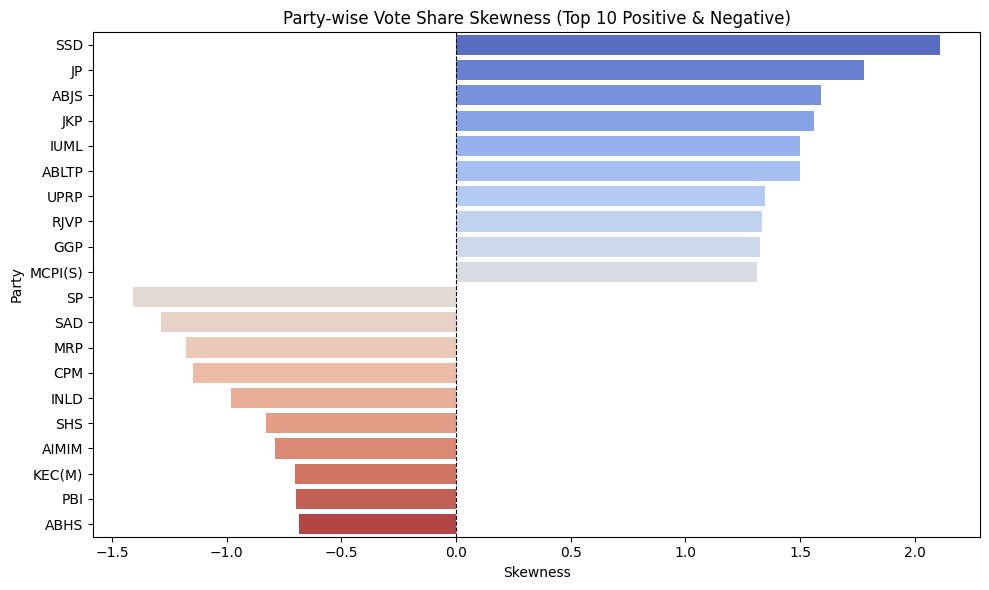

/tmp/ipython-input-35-2077979073.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


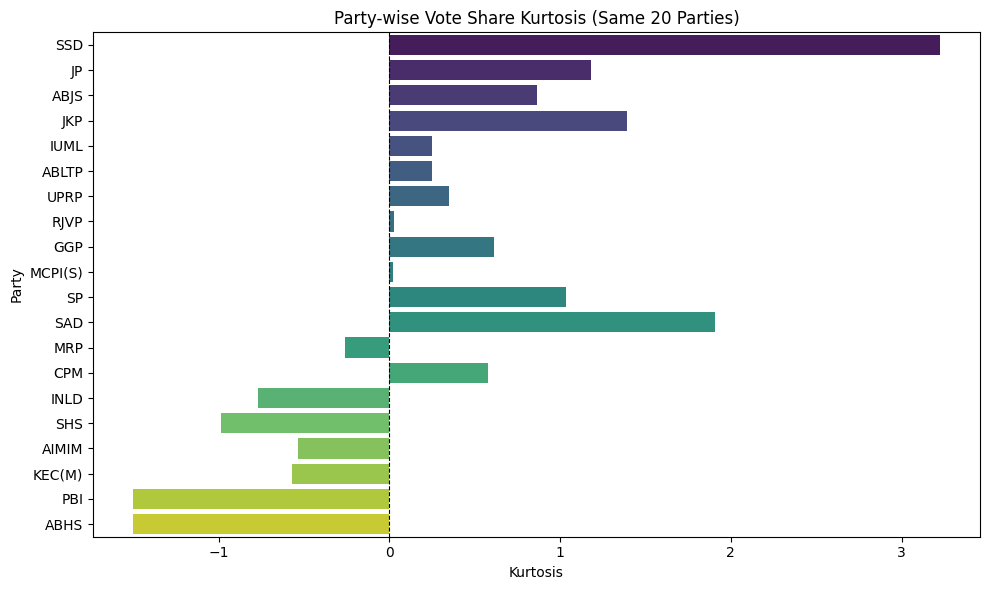

In [35]:
# Step a: Select top and bottom 10 parties based on Skewness
top_10_skewed = party_vote_stats.sort_values(by='Skewness', ascending=False).head(10)
bottom_10_skewed = party_vote_stats.sort_values(by='Skewness', ascending=True).head(10)

# Combine both for plotting
skewed_parties = pd.concat([top_10_skewed, bottom_10_skewed])

# Step b: Bar plot for Skewness
plt.figure(figsize=(10, 6))
sns.barplot(
    data=skewed_parties,
    x='Skewness',
    y='partyabbre',
    palette='coolwarm'
)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.title("Party-wise Vote Share Skewness (Top 10 Positive & Negative)")
plt.xlabel("Skewness")
plt.ylabel("Party")
plt.tight_layout()
plt.show()

# Step c: Bar plot for Kurtosis
plt.figure(figsize=(10, 6))
sns.barplot(
    data=skewed_parties,
    x='Kurtosis',
    y='partyabbre',
    palette='viridis'
)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.title("Party-wise Vote Share Kurtosis (Same 20 Parties)")
plt.xlabel("Kurtosis")
plt.ylabel("Party")
plt.tight_layout()
plt.show()


###Observation

## i. Visual Figures

### Figure 1: Party-wise Skewness in Vote Share  
This bar plot shows how vote shares were tilted across years for major political parties.

- Parties with high skewness like SSD, JP, and ABJS had erratic performances with one big spike in vote share, often in a single election.
- Parties with mild or negative skewness like SP, SAD, and CPM performed more consistently over time, with fewer dramatic changes.

---

### Figure 2: Party-wise Kurtosis in Vote Share  
This bar plot shows how extreme or balanced the vote share fluctuations were for each party.

- Parties with high kurtosis like JP, RJVP, and SSD had sharp peaks and sudden drops in support, reflecting highly concentrated or unstable vote share patterns.
- Parties with moderate kurtosis (~1–3), like SP, SAD, and CPM, showed some variability but no extreme outliers. Their vote performance was more balanced.

---

### ii. Interpretations Under Each Figure

- Skewness helps identify how uneven the vote distribution was — whether it leaned heavily toward one successful election or was more consistent.  
- Kurtosis shows whether a party’s vote performance had sharp highs and lows or remained fairly steady.

These visualizations make patterns easier to detect than raw numbers, especially when comparing multiple parties side by side.

---

### iii. Do skewness and kurtosis values align with the vote share trends you saw earlier?

Yes, they match well.  
- Parties like JP and SSD, which had high vote shares in just one or two elections and disappeared later, show high skewness and kurtosis — confirming their status as short-lived successes.  
- Parties like PM, SP, and SAD, which performed reliably across years, have low skewness and moderate kurtosis, reflecting their long-term stability.

The visuals confirm earlier findings and help reinforce patterns identified from historical election data.

---

### iv. What does the visual pattern reveal that the table may not?

- The plots offer instant visual clarity, showing which parties are consistent versus volatile.  
- Tables may show similar averages, but charts highlight outliers — those parties that spiked once or fluctuated wildly.  
- It becomes clear which parties are one-hit wonders and which have broad or enduring support.  
- Visual patterns can also help suggest future risks for unstable parties or the enduring value of political consistency.



##29.ANOVA Analysis of Party Vote Share Across States – Lok Sabha

I analyze whether a selected party’s vote share differs significantly across Indian states, using ANOVA (Analysis of Variance).

ANOVA Result for BJP
F-statistic: 5.6365
P-value: 0.0000


/tmp/ipython-input-36-766634846.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x='st_name', y='vote_share_percent', palette='Set3')


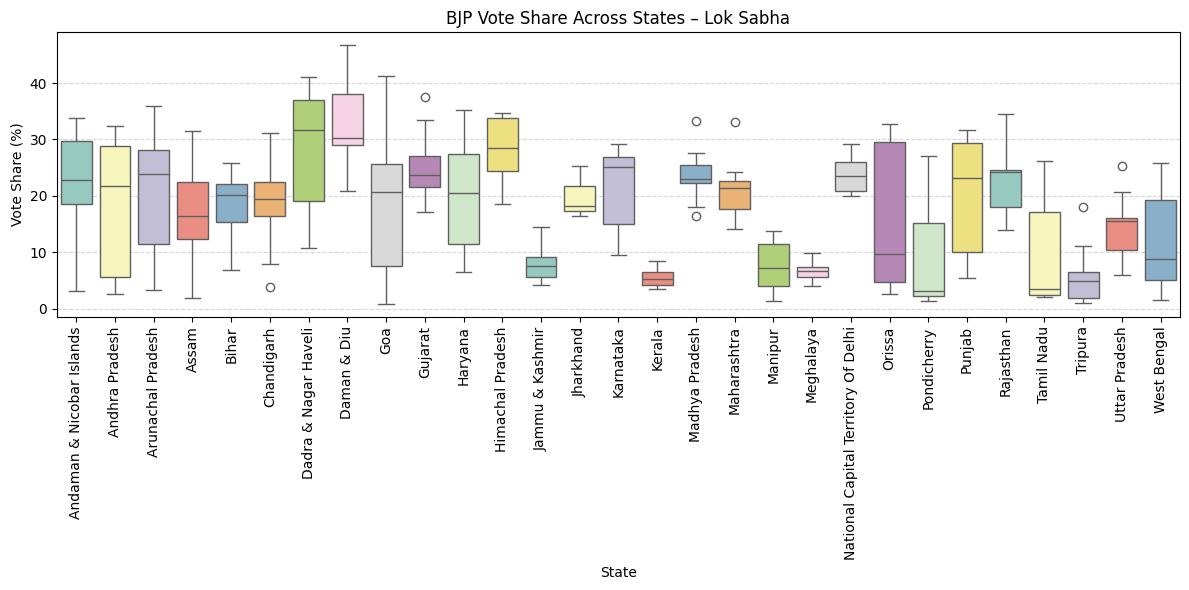

In [36]:
from scipy.stats import f_oneway
# Step a: Choose a party (e.g., 'BJP')
selected_party = 'BJP'

# Step b: Calculate vote share % of that party in each state per year
# Filter only rows for selected party
party_df = lok_df[lok_df['partyabbre'] == selected_party].copy()

# Calculate vote share %: (votes polled / electors) × 100
party_df['vote_share_percent'] = np.where(
    party_df['electors'] > 0,
    (party_df['totvotpoll'] / party_df['electors']) * 100,
    np.nan
)

# Group by state and year and take average vote share per state-year
state_vote_share = (
    party_df.groupby(['st_name', 'year'])['vote_share_percent']
    .mean()
    .reset_index()
)

# Step c: Filter states with data for at least 3 elections
state_counts = state_vote_share['st_name'].value_counts()
eligible_states = state_counts[state_counts >= 3].index.tolist()
filtered_data = state_vote_share[state_vote_share['st_name'].isin(eligible_states)]

# Step d: Run ANOVA test (vote share by state)
grouped_votes = [
    group['vote_share_percent'].dropna().values
    for _, group in filtered_data.groupby('st_name')
]

f_stat, p_value = f_oneway(*grouped_votes)
print(f"ANOVA Result for {selected_party}")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Step f: Boxplot to visualize variation by state
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_data, x='st_name', y='vote_share_percent', palette='Set3')
plt.title(f"{selected_party} Vote Share Across States – Lok Sabha")
plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("Vote Share (%)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


###Observation

### i. What does the ANOVA test help you determine in this context?

1. → ANOVA checks whether BJP’s average vote share is the same across all states or if there are significant differences.  
It does this by comparing variations between states to variations within each state.

---

### ii. What is the meaning of the F-statistic and p-value in your result?

1. → The F-statistic is 5.6365, showing that the variation between state vote shares is larger than random chance would expect.  
The p-value is 0.0000, meaning the result is statistically significant.

2. → A low p-value (below 0.05) is important because it means the differences in BJP’s vote share across states are not random — they are real and meaningful.

---

### iii. Based on your result, can you say that BJP's vote share is the same in every state? Why or why not?

1. → No, because the p-value is very low (0.0000), which means BJP’s vote share varies significantly from one state to another.

---

### iv. Which states appear to be BJP’s strongholds and which are weak spots based on the boxplot?

1. → BJP's strongholds appear to include Gujarat, Madhya Pradesh, Rajasthan, and Uttar Pradesh where vote share is high.  
Their weak spots seem to be Kerala, Tamil Nadu, and West Bengal where the vote share is much lower.

---

### v. Why is this analysis useful in real-world politics or strategy?

1. → It helps parties like BJP understand where they are doing well and where they need to improve.  
This can guide campaign efforts, resource planning, and state-specific messaging for future elections.


---



##30.Statistical Comparison of Vote Share – Ruling vs Opposition Parties – Lok Sabha

The goal of this analysis is to compare the vote share of the ruling party with that of selected opposition parties over the years.  
Using statistical analysis (t-test), check if the ruling party has a significantly higher vote share in Lok Sabha elections.

In [39]:
# Step b: Party Grouping

# Define ruling and opposition parties
ruling_party = 'BJP'
opposition_parties = ['INC', 'SP', 'DMK', 'AITC', 'BSP']
selected_parties = [ruling_party] + opposition_parties

# Filter data for selected parties
party_df = lok_df[lok_df['partyabbre'].isin(selected_parties)].copy()


### Party Grouping Explanation

- Ruling Party: BJP (Bharatiya Janata Party)  
- Opposition Parties Included: INC, SP, DMK, AITC, BSP  
- A new column called group was added to classify each party as:
  - "Ruling" for BJP  
  - "Opposition" for the others


In [40]:
# Step c: Vote Share Calculation (ECI method)

# Total national votes per year
total_votes_year = lok_df.groupby('year')['totvotpoll'].sum().reset_index(name='total_votes')

# Party-wise total votes per year
party_votes_year = party_df.groupby(['year', 'partyabbre'])['totvotpoll'].sum().reset_index(name='party_votes')

# Merge and calculate vote share %
vote_share_df = pd.merge(party_votes_year, total_votes_year, on='year')
vote_share_df['vote_share_percent'] = (vote_share_df['party_votes'] / vote_share_df['total_votes']) * 100

# Add group column
vote_share_df['group'] = vote_share_df['partyabbre'].apply(lambda x: 'Ruling' if x == ruling_party else 'Opposition')


### Vote Share Calculation

I calculated the vote share for each party using the official ECI formula:

(party_votes / total_votes) * 100

This ensures a fair, year-wise comparison of performance.


In [41]:
# Step d: T-Test Analysis

from scipy.stats import ttest_ind

# Split vote shares by group
ruling_votes = vote_share_df[vote_share_df['group'] == 'Ruling']['vote_share_percent']
opposition_votes = vote_share_df[vote_share_df['group'] == 'Opposition']['vote_share_percent']

# Perform independent t-test
t_stat, p_val = ttest_ind(ruling_votes, opposition_votes, equal_var=False)

print(f" T-statistic: {t_stat:.4f}")
print(f" P-value: {p_val:.4f}")


 T-statistic: 2.9276
 P-value: 0.0075


### T-Test Results


Since the p-value (0.0075) < 0.05, the result is statistically significant.

This means the difference in vote share between the ruling party (BJP) and the selected opposition parties (INC, DMK, SP, AITC, BSP) is not due to random chance.  

The ruling party’s vote share is significantly higher than that of the opposition over the years.


/tmp/ipython-input-42-3394712154.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=vote_share_df, x='group', y='vote_share_percent', palette='Set2')


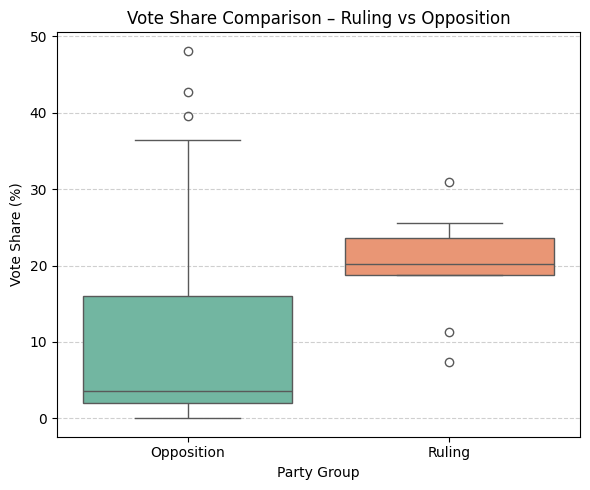

In [42]:
# Step e: Visualization – Boxplot

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.boxplot(data=vote_share_df, x='group', y='vote_share_percent', palette='Set2')
plt.title("Vote Share Comparison – Ruling vs Opposition")
plt.ylabel("Vote Share (%)")
plt.xlabel("Party Group")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


- The Ruling party appears to receive stronger and more uniform voter support across elections.
- The Opposition has a few strong performers but also many low-performing ones, suggesting inconsistent support.


###  Final Insight

Based on the t-test and the boxplot, we can say that the ruling party (BJP) generally holds a stronger and statistically significant vote share advantage over its opposition.   

This highlights the dominance of the ruling party and reflects voter consolidation.

Such a comparison is useful to understand how centralized or fragmented electoral power is in Indian politics, and whether ruling parties truly command national support.


##31.Party-Wise Vote Share Correlation Analysis – Lok Sabha Elections

This section examines how the vote shares of top political parties relate to each other using correlation analysis.

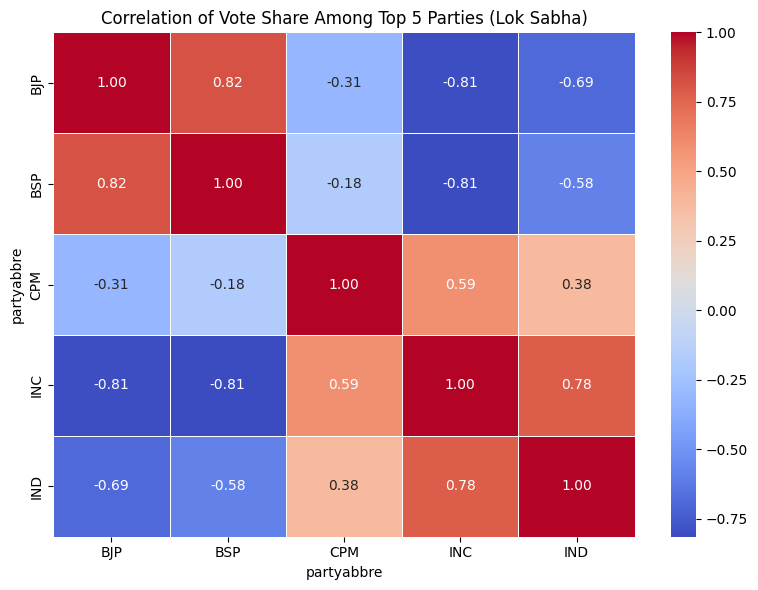

In [43]:
# Step a: Compute Total Votes per Party per Year
party_votes = (
    lok_df.groupby(['year', 'partyabbre'])['totvotpoll']
    .sum()
    .reset_index(name='party_votes')
)

# Step b: Compute Total National Votes per Year
total_votes = (
    lok_df.groupby('year')['totvotpoll']
    .sum()
    .reset_index(name='total_votes')
)

# Step c: Calculate Vote Share Percentage
vote_share_df = pd.merge(party_votes, total_votes, on='year')
vote_share_df['vote_share_percent'] = (vote_share_df['party_votes'] / vote_share_df['total_votes']) * 100

# Step d: Identify Top 5 Parties by Total Votes
top_5_parties = (
    vote_share_df.groupby('partyabbre')['party_votes']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

# Step e: Filter Dataset to Include Only Top 5 Parties
top5_df = vote_share_df[vote_share_df['partyabbre'].isin(top_5_parties)]

# Step f: Reshape for Correlation Analysis
pivot_df = top5_df.pivot(index='year', columns='partyabbre', values='vote_share_percent').fillna(0)

# Step g: Calculate Correlation Matrix
correlation_matrix = pivot_df.corr()
correlation_matrix

# Step h: Visualize Using a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation of Vote Share Among Top 5 Parties (Lok Sabha)")
plt.tight_layout()
plt.show()


###Observation

### i. Which two parties show the highest positive correlation in their vote share trends?
- BJP and BSP have the highest positive correlation (0.82).
1. This could be because their vote shares increased in similar time periods or regions. Although ideologically different, both parties may have benefitted from anti-INC waves or voter shifts away from traditional Congress dominance.

---

### ii. Which two parties show the strongest negative correlation?
- BJP and INC, and BSP and INC both show a strong negative correlation of -0.81.
1. Yes, this suggests that one party’s gain is often at the cost of the other. As BJP or BSP rose, INC’s vote share declined, indicating they are competing in the same voter base or political space.

---

### iii. Is there any pair of parties that show almost zero correlation?
- BSP and CPM have a near-zero correlation (-0.18).
1. This suggests that their vote shares do not move together. It may be due to operating in different regions — CPM is mostly concentrated in Kerala and parts of Bengal, while BSP is strong in Uttar Pradesh and nearby states.

---

### iv. How do independent candidates (IND) correlate with major national parties like BJP or INC?
- IND and INC show a positive correlation (0.78), while IND and BJP have a negative correlation (-0.69).
1. When INC does well, independents also perform better — possibly due to voter support being more scattered in INC-led regions. When BJP dominates, independent candidates may lose vote share, possibly due to more consolidated voter preference.

---

### v. What does the heatmap tell us about competition vs. coexistence?
1. Parties with negative correlation (like BJP vs. INC) are likely direct competitors, vying for the same electorate.
2. Positive correlations (like BJP and BSP) suggest coexistence or parallel growth, possibly because of growth in different regions or among distinct voter groups.

---

### vi. How could a political strategist use this information?
1. A strategist could use these patterns for alliance decisions. For example, since BJP and BSP move together, they could potentially coordinate rather than compete in overlapping regions. On the other hand, strong negative correlation between INC and BJP signals direct rivalry — helpful for opposition strategy and resource targeting.


##32.Vote Share Percentage of Each Party – Lok Sabha Elections

In this step, I calculate the vote share percentage of each political party for every Lok Sabha election year.

In [45]:
# Step a: Group by Party and Year to get total votes per party per year
party_year_votes = (
    lok_df.groupby(['year', 'partyabbre'])['totvotpoll']
    .sum()
    .reset_index(name='party_votes')
)

# Step b: Group by Year for total national votes cast per year
year_total_votes = (
    lok_df.groupby('year')['totvotpoll']
    .sum()
    .reset_index(name='total_votes')
)

# Step c: Merge the two datasets on year
vote_share_df = pd.merge(party_year_votes, year_total_votes, on='year')

# Step d: Calculate vote share percentage for each party in each year
vote_share_df['vote_share_percent'] = (vote_share_df['party_votes'] / vote_share_df['total_votes']) * 100

print(vote_share_df)

      year partyabbre  party_votes  total_votes  vote_share_percent
0     1977        ADK      5480378    188917504            2.900937
1     1977        BLD     78062828    188917504           41.321120
2     1977        CPI      5322088    188917504            2.817149
3     1977        CPM      8113659    188917504            4.294816
4     1977        DMK      3323320    188917504            1.759138
...    ...        ...          ...          ...                 ...
1959  2014        VOP         1089    553802946            0.000197
1960  2014        VSP          263    553802946            0.000047
1961  2014       WPOI       228645    553802946            0.041286
1962  2014      YSRCP     13995435    553802946            2.527151
1963  2014        YUS         4578    553802946            0.000827

[1964 rows x 5 columns]


###Observation

### i. Which parties had the highest vote shares in each year?
1. In 1977, BLD had the highest vote share, over 41%, showing dominant support during that election.
2. In later years (like 2014), no party crosses such a high threshold. Instead, multiple parties have smaller shares, showing fragmentation.
3. A single national party does not consistently dominate across all years. Dominance varies by election and context.

---

### ii. Which years saw large vote share changes for any party?
1. BLD’s high vote share in 1977 followed the Emergency period, reflecting a public shift toward the Janata alliance and away from Congress.
2. In 2014, YSRCP appears with a sizable vote share, indicating its rise as a regional force after the bifurcation of Andhra Pradesh.
3. These changes often reflect major political events like alliances, splits, or leadership changes.

---

### iii. Are there any years where multiple parties had similar vote shares?
1. In 1977, CPI and ADK had similar vote shares around 2.8–2.9%.
2. This suggests closer competition and a more even voter distribution in some states or segments.
3. Such similarity reflects voter uncertainty or divided regional preferences.

---

### iv. Can you spot any long-term trends?
1. BLD had a huge presence in 1977 but disappears from later years, indicating a rapid decline.
2. YSRCP does not appear in earlier years but shows a strong vote share in 2014, revealing its growth as a rising regional party.
3. This suggests that new parties can emerge quickly, while old ones can fade based on voter sentiment and political shifts.

---

### v. What does the vote share tell us about the nature of Indian elections?
1. The data shows fragmentation over time — more parties receiving smaller chunks of the vote instead of one dominating party.
2. Regional parties like YSRCP gain significant vote share in their areas, challenging national parties in specific states.
3. Coalition politics plays a key role — no single party dominates everywhere, so alliances are often essential to form governments.



##33. Vote Share Trends of Top 5 Parties Over Time – Lok Sabha

This section visualizes how vote shares of India’s top 5 political parties have changed across different Lok Sabha elections.

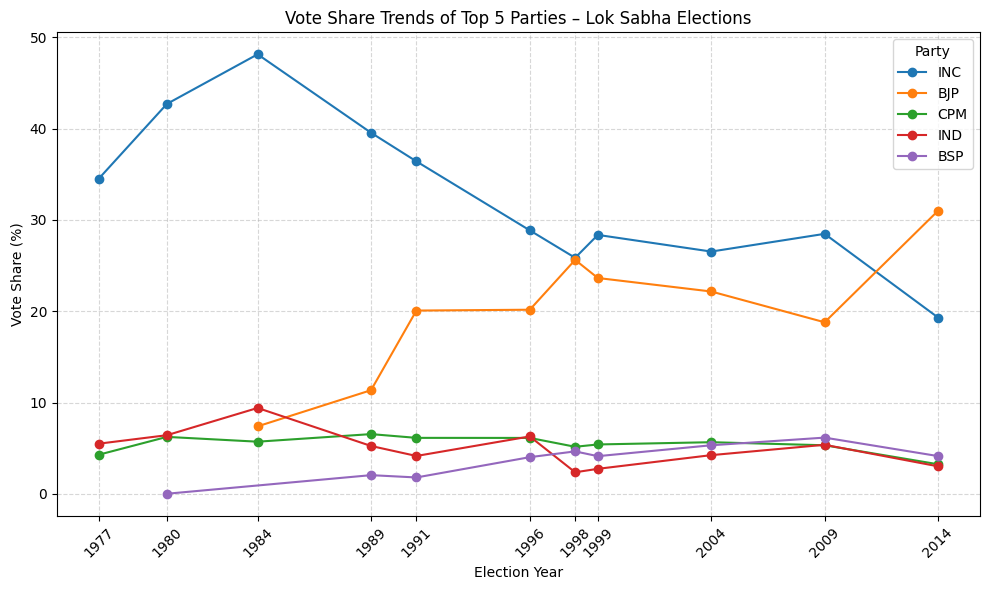

In [46]:
# Step a: Identify the Top 5 Parties by total votes across all years
top_5_parties = (
    vote_share_df.groupby('partyabbre')['party_votes']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

# Step b: Filter data for only the top 5 parties
top5_df = vote_share_df[vote_share_df['partyabbre'].isin(top_5_parties)]

# Step c: Line chart showing vote share trends over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for party in top_5_parties:
    party_data = top5_df[top5_df['partyabbre'] == party]
    plt.plot(
        party_data['year'],
        party_data['vote_share_percent'],
        marker='o',
        label=party
    )

# Step d: Label the chart
plt.title("Vote Share Trends of Top 5 Parties – Lok Sabha Elections")
plt.xlabel("Election Year")
plt.ylabel("Vote Share (%)")
plt.xticks(sorted(vote_share_df['year'].unique()), rotation=45)
plt.legend(title="Party")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


###Observation

### i. Which party had the most consistent vote share over the years?
- CPM had the most consistent vote share. Its line stayed steady across elections, with only small changes, showing a stable base of supporters.

### ii. Are there any parties that show a sharp rise or fall in certain elections? What could be the reasons?
- BJP showed sharp rises between 1989 and 1991, and again from 1996 to 1998. These jumps align with growing national popularity and leadership shifts.  
- INC dropped steeply after 1984, which may reflect anti-incumbency and political realignments after the Emergency and the rise of new parties.

### iii. Which party had the highest peak in vote share, and in which year?
- INC had the highest vote share peak, reaching nearly 49% in 1984, likely driven by a sympathy wave following Indira Gandhi’s assassination.

### iv. Did any party lose ground steadily over time?
- INC steadily declined from 1984 to 2014, losing its earlier dominance and reflecting growing competition from regional and national parties like BJP.

### v. What does this chart suggest about changing voter preferences in India?
- Voter preferences have become more fragmented and competitive.  
  National parties like INC no longer dominate as they once did, and the rise of BJP and regional stability of parties like CPM and BSP highlight India's diverse political landscape.  
  This shift shows that Indian voters now consider more choices, making alliances and regional dynamics increasingly important.


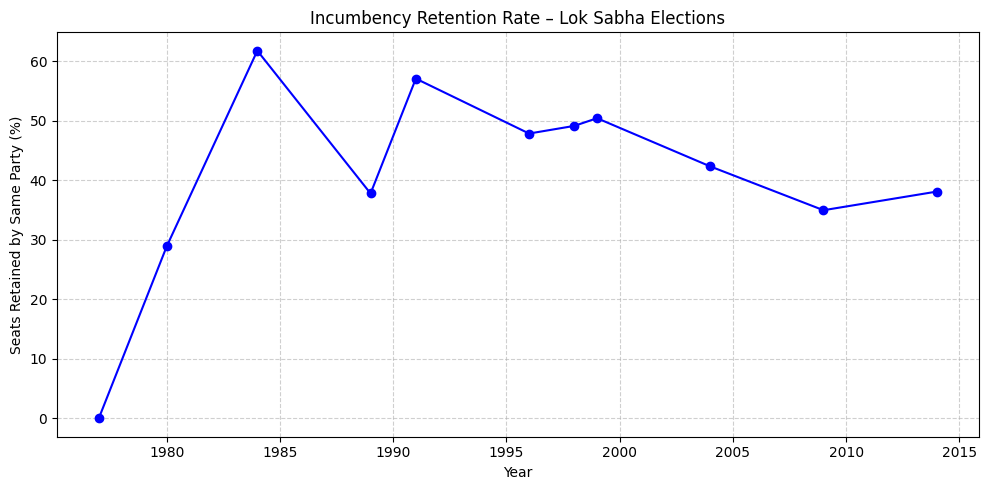

In [48]:
# Step a: Rank Candidates in Each Constituency and Year

lok_df['rank'] = (
    lok_df.groupby(['year', 'st_name', 'pc_no'])['totvotpoll']
    .rank(method='first', ascending=False)
)

# Keep only winners (rank 1)
winners_df = lok_df[lok_df['rank'] == 1].copy()

# Step b: Track Winning Party Across Elections

# Sort by year for each constituency
winners_df = winners_df.sort_values(by=['st_name', 'pc_no', 'year'])

# For each constituency, shift the party column to compare current with previous winner
winners_df['prev_party'] = winners_df.groupby(['st_name', 'pc_no'])['partyabbre'].shift(1)

# Check if the same party won again
winners_df['retained'] = winners_df['partyabbre'] == winners_df['prev_party']

# Step c: Calculate Incumbency Retention Percentage by Year

incumbency_rate = (
    winners_df.groupby('year')['retained']
    .mean()
    .reset_index(name='retention_rate')
)

# Convert to percentage
incumbency_rate['retention_rate'] = incumbency_rate['retention_rate'] * 100

# Step d: Visualize the Incumbency Trend
plt.figure(figsize=(10, 5))
plt.plot(incumbency_rate['year'], incumbency_rate['retention_rate'], marker='o', linestyle='-', color='blue')
plt.title("Incumbency Retention Rate – Lok Sabha Elections")
plt.xlabel("Year")
plt.ylabel("Seats Retained by Same Party (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


###Observation

### i. In which years did incumbents retain the highest proportion of seats?
- The highest retention occurred in 1984, where around 60% of incumbents were re-elected. This was the peak of incumbency success during the period observed.

### ii. Are there election years where a major drop in retention occurred? What might have caused that?
- A major drop is seen in 1989, where the retention rate fell sharply to around 30%. This likely reflects anti-incumbency sentiment and political instability following the decline of the Congress party’s dominance after the assassination of Indira Gandhi.

### iii. Does the trend suggest voter satisfaction with sitting governments or frequent desire for change?
- The trend suggests a frequent desire for change. Although there are occasional peaks in retention, the overall pattern is volatile, with multiple sharp declines, indicating that voters often choose to vote out sitting representatives.

### iv. What political or historical events could explain high or low retention years?
- 1984: High retention likely due to the sympathy wave after Indira Gandhi’s assassination.
- 1989: Low retention connected to scandals like Bofors and the collapse of public trust in Congress.
- 1996: Moderate retention linked to political churn and emergence of coalitions.
- 2004 & 2009: Higher retention during relative economic stability and successful coalition management.
- 2014: Drop in retention, likely from anti-incumbency toward the UPA and a strong pro-BJP wave.

### v. How does this help us understand the stability of party support in Indian constituencies over time?
- The data reveals that Indian voter behavior is dynamic, and party loyalty is not guaranteed. Retention rates reflect how national sentiments, leadership shifts, and major events impact even local-level outcomes. Frequent swings signal that constituency support is sensitive to broader political narratives, making electoral stability a challenge in many regions.


##35.Measuring Vote Share Swing for Top Political Parties – Lok Sabha

This section analyzes how much each top party’s vote share has changed from one election to the next, helping us track gains or losses in popularity over time.

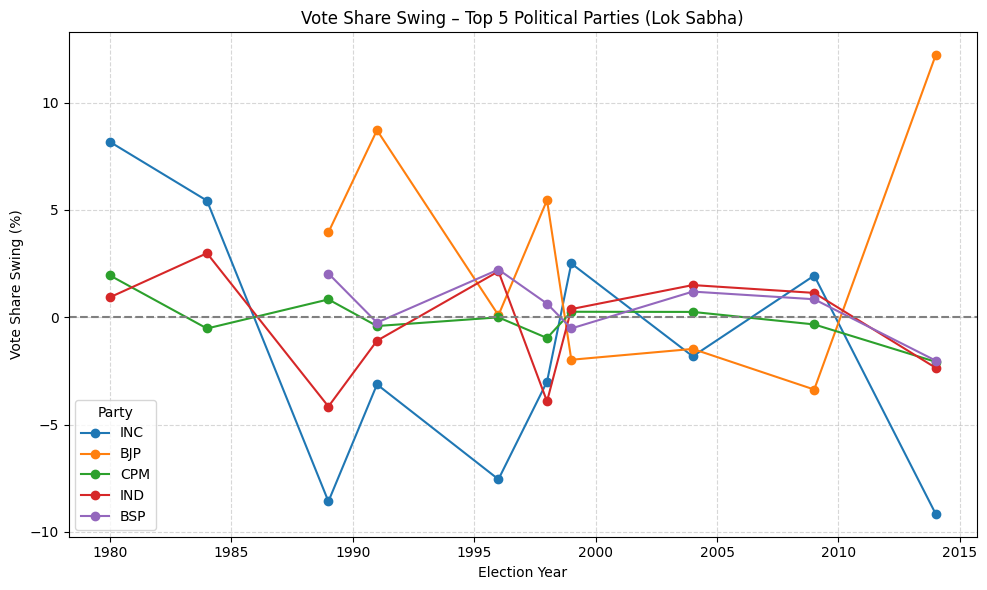

In [49]:
# Step a: Reuse previously identified top 5 parties by vote share
top_5_parties = (
    vote_share_df.groupby('partyabbre')['party_votes']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

# Filter vote share data for just these parties
top5_votes = vote_share_df[vote_share_df['partyabbre'].isin(top_5_parties)].copy()

# Step b: Calculate vote share swing (year-over-year change)

# Sort data by party and year
top5_votes = top5_votes.sort_values(by=['partyabbre', 'year'])

# Calculate swing: current year's vote share - previous year's vote share
top5_votes['vote_share_swing'] = top5_votes.groupby('partyabbre')['vote_share_percent'].diff()

# Step c: Plot vote share swing over time for each party
plt.figure(figsize=(10, 6))

for party in top_5_parties:
    swing_data = top5_votes[top5_votes['partyabbre'] == party]
    plt.plot(
        swing_data['year'],
        swing_data['vote_share_swing'],
        marker='o',
        label=party
    )

# Horizontal line at 0% to separate gain vs loss
plt.axhline(0, color='gray', linestyle='--')
plt.title("Vote Share Swing – Top 5 Political Parties (Lok Sabha)")
plt.xlabel("Election Year")
plt.ylabel("Vote Share Swing (%)")
plt.legend(title="Party")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


###Observation

### i. Which parties showed the largest positive swing in any year?  
- BJP showed the biggest positive swing in 2014, with a gain of around 10 percentage points.  
- This sharp rise was likely driven by a strong anti-incumbency wave, the popularity of Narendra Modi, and effective campaign strategies following dissatisfaction with the UPA government.

---

### ii. Identify the years where a party lost significant vote share. Are these linked to any political events or major leadership changes?  
- INC had major declines in 1989 and 2014.  
  - In 1989, the Bofors scandal and declining public trust led to losses.  
  - In 2014, scandals, economic dissatisfaction, and Modi's rise contributed to a historic defeat.
- BJP saw a drop in 2004, possibly linked to the surprise loss of NDA despite the "India Shining" campaign.

---

### iii. Which party had the most volatile swing pattern (frequent ups and downs)?  
- INC had the most volatile trend with several sharp rises and falls from the 1980s through 2014, reflecting fluctuating public trust and changing leadership.

---

### iv. Are there any consistent gainers or losers across multiple elections?  
- BJP showed consistent gains from the late 1980s to 2014, especially strong between 1996–1998 and 2009–2014.  
- INC showed a gradual decline, especially after 1984.  
- CPM and IND had relatively flat or declining trends over time.

---

### v. What do these swings reveal about public sentiment or shifts in political alliances?  
- Large swings reflect changing public sentiment, often influenced by scandals, leadership, and national issues.  
- Sharp rises point to political waves or strong leadership appeal.  
- Declines suggest voter fatigue, corruption concerns, or alliance breakdowns.  
- The data also indicates that coalitions and regional shifts play an increasing role, as national parties face more fragmented voter bases.


#Final Conclusion: Lok Sabha Elections Analysis (1977–2014)

This project explored the Indian Lok Sabha elections from 1977 to 2014. The goal was to clean the data, analyze voting patterns, party performance, voter turnout, and other important election-related trends.

I started by preparing the data, fixing missing values, and making sure party names and constituency names were consistent. This helped make the analysis more accurate and meaningful.

One of the major trends I observed was that voter turnout has increased over time, showing greater public involvement in elections. At the same time, the number of candidates and parties has also grown, which means Indian elections have become more competitive and diverse.

In terms of party performance, Congress was clearly dominant in the earlier years, but its vote share has steadily gone down. On the other hand, BJP has grown stronger, especially after the 1990s and became the leading party in later elections. Some regional parties like DMK, SP, and AITC have also had strong performances in their respective states.

I also looked at gender participation and found that although fewer women contest elections, their win rate is often better than male candidates. This shows that when women do contest, they tend to be strong candidates.

I analyzed vote share and seat share over time. It became clear that a higher vote share doesn't always mean more seats because of how the electoral system works. I also studied vote swing to see how a party's popularity changed from one election to the next, and tracked how often parties managed to retain the same seats (incumbency).

Overall, this analysis shows how Indian elections have changed over the decades. Voter preferences shift, new parties rise, old ones lose ground, and regional politics plays a huge role. This kind of data analysis helps to understand how democracy in India is evolving and gives useful insights into public opinion, political strategy, and electoral behavior.
